In [6]:
import os

os.environ['PIP_CONFIG_FILE'] = '/data/yarn/workspace/22325781_omega-sbrf-ru/notebooks/pip.ini'
os.environ['LD_LIBRARY_PATH'] = '/usr/lib64/security'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.integrate import quad, simps
from scipy.optimize import minimize
from scipy.special import erf, gamma, gammainc, betainc, beta
from scipy.stats import pareto, weibull_min, lognorm
from scipy.interpolate import make_interp_spline, interp1d
from numpy.polynomial.polynomial import Polynomial
from datetime import datetime
import re
import gc

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit, newton

from sklearn.preprocessing import MinMaxScaler

/home/22325781_omega-sbrf-ru/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


## Сборка детальных данных с Росстат (биллютени)

In [115]:
df_2015_path = r'2015.xlsx'
df_2015 = pd.read_excel(df_2015_path, header=None)
df_2015.reset_index(drop=True, inplace=True)
df_2015 = df_2015.loc[4:8, 2:22]
df_2015 = df_2015.dropna()
df_2015 = df_2015.T
df_2015.columns = ['Бакет', 'Кол-во', 'Доля', 'Ср зп'] 
df_2015['Кол-во'] = pd.to_numeric(df_2015['Кол-во'])   
df_2015['Ср зп'] = pd.to_numeric(df_2015['Ср зп'])
df_2015['Доля'] = df_2015['Кол-во'] / df_2015['Кол-во'].sum()
df_2015['cumsum'] = df_2015['Доля'].cumsum()
df_2015['fot'] = df_2015['Кол-во'] * df_2015['Ср зп']
df_2015['fot_cumsum'] = df_2015['fot'].cumsum()
df_2015['fot_cdf'] = df_2015['fot_cumsum'] / df_2015['fot'].sum()
df_2015

,Бакет,Кол-во,Доля,Ср зп,cumsum,fot,fot_cumsum,fot_cdf
2,"до 5965,0",411270.14,0.014207,4905.2,0.014207,2.017362e+09,2.017362e+09,0.002062
3,"от 5965,1 до 7400,0",899296.37,0.031065,6653.8,0.045271,5.983738e+09,8.001100e+09,0.008177
4,"от 7400,1 до 9000,0",991619.65,0.034254,8258.0,0.079525,8.188795e+09,1.618990e+10,0.016546
5,"от 9000,1 до 10600,0",1151386.67,0.039773,9835.1,0.119298,1.132400e+10,2.751390e+10,0.028119
6,"от 10600,1 до 12200,0",1245737.66,0.043032,11454.2,0.162330,1.426893e+10,4.178283e+10,0.042702
7,"от 12200,1 до 13800,0",1223963.74,0.042280,13027.4,0.204609,1.594507e+10,5.772789e+10,0.058997
8,"от 13800,1 до 15400,0",1306782.82,0.045141,14630.1,0.249750,1.911836e+10,7.684626e+10,0.078536
9,"от 15400,1 до 17000,0",1295571.37,0.044753,16225.6,0.294503,2.102142e+10,9.786768e+10,0.100020
10,"от 17000,1 до 18600,0",1320309.31,0.045608,17822.4,0.340111,2.353108e+10,1.213988e+11,0.124068
11,"от 18600,1 до 21800,0",2403579.38,0.083027,20202.0,0.423138,4.855711e+10,1.699559e+11,0.173693


In [8]:
df_2017_path = r'2017.xlsx'
df_2017 = pd.read_excel(df_2017_path, header=None)
df_2017.reset_index(drop=True, inplace=True)
df_2017 = df_2017.loc[4:9, 2:22]
df_2017 = df_2017.dropna()
df_2017 = df_2017.T
df_2017 = df_2017.drop(df_2017.columns[1], axis=1)
df_2017.columns = ['Бакет', 'Кол-во', 'Доля', 'Ср зп'] 
df_2017['Кол-во'] = pd.to_numeric(df_2017['Кол-во'])   
df_2017['Ср зп'] = pd.to_numeric(df_2017['Ср зп'])
df_2017['Доля'] = df_2017['Кол-во'] / df_2017['Кол-во'].sum()
df_2017['cumsum'] = df_2017['Доля'].cumsum()
df_2017['fot'] = df_2017['Кол-во'] * df_2017['Ср зп']
df_2017['fot_cumsum'] = df_2017['fot'].cumsum()
df_2017['fot_cdf'] = df_2017['fot_cumsum'] / df_2017['fot'].sum()
df_2017

,Бакет,Кол-во,Доля,Ср зп,cumsum,fot,fot_cumsum,fot_cdf
2,"до 7500,0",491973.90,0.018211,6341.3,0.018211,3.119754e+09,3.119754e+09,0.002969
3,"от 7500,1 до 9000,0",779664.07,0.028860,8252.1,0.047071,6.433866e+09,9.553620e+09,0.009091
4,"от 9000,1 до 10600,0",855144.93,0.031654,9852.1,0.078726,8.424973e+09,1.797859e+10,0.017108
5,"от 10600,1 до 12200,0",984121.65,0.036429,11430.1,0.115154,1.124861e+10,2.922720e+10,0.027812
6,"от 12200,1 до 13800,0",995246.92,0.036840,13037.9,0.151995,1.297593e+10,4.220313e+10,0.040160
7,"от 13800,1 до 15400,0",1026660.21,0.038003,14617.8,0.189998,1.500751e+10,5.721065e+10,0.054441
8,"от 15400,1 до 17000,0",1095299.98,0.040544,16234.1,0.230542,1.778121e+10,7.499186e+10,0.071361
9,"от 17000,1 до 18600,0",1139650.25,0.042186,17816.2,0.272728,2.030424e+10,9.529609e+10,0.090682
10,"от 18600,1 до 21800,0",2142949.52,0.079324,20199.9,0.352052,4.328737e+10,1.385835e+11,0.131874
11,"от 21800,1 до 25000,0",2107757.73,0.078022,23399.4,0.430074,4.932027e+10,1.879037e+11,0.178806


In [9]:
df_2019_path = r'2019.xlsx'
df_2019 = pd.read_excel(df_2019_path, header=None)
df_2019.reset_index(drop=True, inplace=True)
df_2019 = df_2019.loc[4:9, 2:29]
df_2019 = df_2019.dropna()
df_2019 = df_2019.T
df_2019.columns = ['Бакет', 'Кол-во', 'Доля', 'Ср зп']
df_2019['Кол-во'] = pd.to_numeric(df_2019['Кол-во'])   
df_2019['Ср зп'] = pd.to_numeric(df_2019['Ср зп'])
df_2019['Доля'] = df_2019['Кол-во'] / df_2019['Кол-во'].sum()
df_2019['cumsum'] = df_2019['Доля'].cumsum()
df_2019['fot'] = df_2019['Кол-во'] * df_2019['Ср зп']
df_2019['fot_cumsum'] = df_2019['fot'].cumsum()
df_2019['fot_cdf'] = df_2019['fot_cumsum'] / df_2019['fot'].sum()
df_2019

,Бакет,Кол-во,Доля,Ср зп,cumsum,fot,fot_cumsum,fot_cdf
2,"до 11280,0",775460.65,0.028622,9454.4,0.028622,7.331515e+09,7.331515e+09,0.005678
3,"от 11280,1 до 12140,0",465346.40,0.017176,11647.7,0.045798,5.420215e+09,1.275173e+10,0.009876
4,"от 12140,1 до 13000,0",471685.48,0.017410,12693.1,0.063208,5.987151e+09,1.873888e+10,0.014513
5,"от 13000,1 до 13850,0",376249.48,0.013887,13430.5,0.077095,5.053219e+09,2.379210e+10,0.018426
6,"от 13850,1 до 14700,0",461746.49,0.017043,14287.0,0.094138,6.596972e+09,3.038907e+10,0.023536
7,"от 14700,1 до 15850,0",525320.70,0.019389,15268.3,0.113527,8.020754e+09,3.840983e+10,0.029748
8,"от 15850,1 до 17000,0",603429.17,0.022272,16470.6,0.135800,9.938840e+09,4.834867e+10,0.037445
9,"от 17000,1 до 18050,0",620438.38,0.022900,17608.8,0.158700,1.092518e+10,5.927384e+10,0.045906
10,"от 18050,1 до 19200,0",654482.55,0.024157,18656.7,0.182856,1.221048e+10,7.148433e+10,0.055363
11,"от 19200,1 до 20350,0",678200.51,0.025032,19800.7,0.207889,1.342884e+10,8.491317e+10,0.065763


In [10]:
df_2021_path = r'2021.xlsx'
df_2021 = pd.read_excel(df_2021_path, header=None)
df_2021.reset_index(drop=True, inplace=True)
df_2021 = df_2021.loc[5:10, 2:30]
df_2021 = df_2021.dropna()
df_2021 = df_2021.T
df_2021.columns = ['Бакет', 'Кол-во', 'Доля', 'Ср зп']
df_2021['Кол-во'] = pd.to_numeric(df_2021['Кол-во'])   
df_2021['Ср зп'] = pd.to_numeric(df_2021['Ср зп'])
df_2021['Доля'] = df_2021['Кол-во'] / df_2021['Кол-во'].sum()
df_2021['cumsum'] = df_2021['Доля'].cumsum()
df_2021['fot'] = df_2021['Кол-во'] * df_2021['Ср зп']
df_2021['fot_cumsum'] = df_2021['fot'].cumsum()
df_2021['fot_cdf'] = df_2021['fot_cumsum'] / df_2021['fot'].sum()
df_2021

,Бакет,Кол-во,Доля,Ср зп,cumsum,fot,fot_cumsum,fot_cdf
2,"до 12792,0",689790.06,0.025071,10253.5,0.025071,7.072762e+09,7.072762e+09,0.004568
3,"от 12792,1 до 13770,0",417366.55,0.015169,13195.6,0.040240,5.507402e+09,1.258016e+10,0.008124
4,"от 13770,1 до 14750,0",394841.41,0.014351,14351.5,0.054591,5.666566e+09,1.824673e+10,0.011784
5,"от 14750,1 до 15990,0",511487.40,0.018590,15356.0,0.073181,7.854401e+09,2.610113e+10,0.016856
6,"от 15990,1 до 16650,0",283687.89,0.010311,16319.0,0.083492,4.629503e+09,3.073063e+10,0.019846
7,"от 16650,1 до 17950,0",500395.77,0.018187,17301.9,0.101679,8.657798e+09,3.938843e+10,0.025437
8,"от 17950,1 до 19250,0",577522.36,0.020990,18652.2,0.122670,1.077206e+10,5.016049e+10,0.032393
9,"от 19250,1 до 20470,0",584911.21,0.021259,19913.7,0.143928,1.164775e+10,6.180824e+10,0.039915
10,"от 20470,1 до 21780,0",636137.67,0.023121,21128.6,0.167049,1.344070e+10,7.524894e+10,0.048595
11,"от 21780,1 до 23080,0",676914.81,0.024603,22453.8,0.191652,1.519931e+10,9.044825e+10,0.058411


In [119]:
df_2023_path = r'2023.xlsx'
df_2023 = pd.read_excel(df_2023_path, header=None)
df_2023.reset_index(drop=True, inplace=True)
df_2023 = df_2023.loc[5:10, 2:32]
df_2023 = df_2023.dropna()
df_2023 = df_2023.T
df_2023.columns = ['Бакет', 'Кол-во', 'Доля', 'Ср зп']
df_2023['Кол-во'] = pd.to_numeric(df_2023['Кол-во'])   
df_2023['Ср зп'] = pd.to_numeric(df_2023['Ср зп'])
df_2023['Доля'] = df_2023['Кол-во'] / df_2023['Кол-во'].sum()
df_2023['cumsum'] = df_2023['Доля'].cumsum()
df_2023['fot'] = df_2023['Кол-во'] * df_2023['Ср зп']
df_2023['fot_cumsum'] = df_2023['fot'].cumsum()
df_2023['fot_cdf'] = df_2023['fot_cumsum'] / df_2023['fot'].sum()
df_2023

,Бакет,Кол-во,Доля,Ср зп,cumsum,fot,fot_cumsum,fot_cdf
2,"до 16242,0",673038.95,0.023945,12955.2,0.023945,8.719354e+09,8.719354e+09,0.004279
3,"от 16242,1 до 18680,0",720190.98,0.025622,17477.5,0.049567,1.258714e+10,2.130649e+10,0.010457
4,"от 18680,1 до 19490,0",259529.16,0.009233,19059.0,0.058801,4.946366e+09,2.625286e+10,0.012885
5,"от 19490,1 до 20300,0",254222.42,0.009045,19887.8,0.067845,5.055925e+09,3.130878e+10,0.015366
6,"от 20300,1 до 21110,0",255412.62,0.009087,20691.2,0.076932,5.284794e+09,3.659358e+10,0.017960
7,"от 21110,1 до 23550,0",725823.16,0.025823,22354.0,0.102755,1.622505e+10,5.281863e+10,0.025923
8,"от 23550,1 до 24360,0",254899.69,0.009069,23960.4,0.111823,6.107499e+09,5.892613e+10,0.028920
9,"от 24360,1 до 25990,0",634661.21,0.022580,25158.1,0.134403,1.596687e+10,7.489300e+10,0.036756
10,"от 25990,1 до 27610,0",577021.14,0.020529,26789.5,0.154932,1.545811e+10,9.035110e+10,0.044343
11,"от 27610,1 до 29240,0",643096.44,0.022880,28418.3,0.177811,1.827571e+10,1.086268e+11,0.053313


In [125]:
## Зарплатные бакеты из биллютеней Росстат
buckets_2023 = parse_buckets(df_2023, 'Бакет')

buckets_2021 = parse_buckets(df_2021, 'Бакет')

buckets_2019 = parse_buckets(df_2019, 'Бакет')

buckets_2017 = parse_buckets(df_2017, 'Бакет')

buckets_2015 = parse_buckets(df_2015, 'Бакет')


In [126]:
# Верхние границы каждого бакета из биллютеней Росстат
upper_point_2023 = get_upper_bounds(buckets_2023)

upper_point_2021 = get_upper_bounds(buckets_2021)

upper_point_2019 = get_upper_bounds(buckets_2019)

upper_point_2017 = get_upper_bounds(buckets_2017)

upper_point_2015 = get_upper_bounds(buckets_2015)

In [122]:
def get_fot_workers_salary(df):
    return df['fot'].sum(), df['Кол-во'].sum(), df['fot'].sum() / df['Кол-во'].sum()

## 2023
fot_2023_bill, num_workers_2023_bill, avg_salary_2023_bill = get_fot_workers_salary(df_2023)

## 2021
fot_2021_bill, num_workers_2021_bill, avg_salary_2021_bill = get_fot_workers_salary(df_2021)

## 2019
fot_2019_bill, num_workers_2019_bill, avg_salary_2019_bill = get_fot_workers_salary(df_2019)

## 2017
fot_2017_bill, num_workers_2017_bill, avg_salary_2017_bill = get_fot_workers_salary(df_2017)

## 2015
fot_2015_bill, num_workers_2015_bill, avg_salary_2015_bill = get_fot_workers_salary(df_2015)

## Сборка тотальных ежемесячных данных по рынку

In [15]:
output_path = r'fot.xlsx'

In [16]:
df_fot = pd.read_excel(output_path)

df_fot = df_fot.groupby(['report_dt', 'region']).agg({
    'fot': 'sum',
    'Value': 'sum'
}).reset_index()

df_fot = df_fot[df_fot['region'] == 'Российская Федерация']

df_fot['avg_salary'] = df_fot['fot'] / df_fot['Value']

df_fot = df_fot.set_index('report_dt', drop=False)

df_fot

,report_dt,region,fot,Value,avg_salary
report_dt,,,,,
2017-01-01,2017-01-01,Российская Федерация,1.480529e+12,43497055.0,34037.457678
2017-02-01,2017-02-01,Российская Федерация,1.534390e+12,43784013.0,35044.521205
2017-03-01,2017-03-01,Российская Федерация,1.644713e+12,43992391.0,37386.309450
2017-04-01,2017-04-01,Российская Федерация,1.709671e+12,44177643.0,38699.914304
2017-05-01,2017-05-01,Российская Федерация,1.729230e+12,44156266.0,39161.593823
...,...,...,...,...,...
2024-02-01,2024-02-01,Российская Федерация,3.347481e+12,43293455.0,77320.725799
2024-03-01,2024-03-01,Российская Федерация,3.748889e+12,43383719.7,86412.349551
2024-04-01,2024-04-01,Российская Федерация,3.585598e+12,43384119.7,82647.702213


## Получение количества людей / ср зп / фота за нужный месяц (тотал ежемес)

In [17]:
def get_total(date, df_fot=df_fot):
    fot_real = df_fot['fot'][date]
    num_workers = df_fot['Value'][date]
    avg_salary = df_fot['avg_salary'][date]

    print(f'{date}: fot_real = {fot_real}')
    print(f'{date}: num_workers = {num_workers}')
    print(f'{date}: avg_salary = {avg_salary}')
    
    return fot_real, num_workers, avg_salary

## Получение коэффициентов для работников для выравнивания

In [18]:
fot_real, num_workers, avg_salary = get_total('2024-04-01')

2024-04-01: fot_real = 3585597805739.93
2024-04-01: num_workers = 43384119.7
2024-04-01: avg_salary = 82647.70221302727


In [19]:
def get_workers_coeff(df):
    coeff_for_workers = df['Кол-во'].max() / df['Кол-во']
    coeff_for_workers = coeff_for_workers.values
    
    return coeff_for_workers

def get_fot_coeff(df):
    coeff_for_fot = df['fot'].max() / df['fot']
    coeff_for_fot = coeff_for_fot.values
    
    return coeff_for_fot

In [129]:
coeff_for_workers_2023 = get_workers_coeff(df_2023)

coeff_for_workers_2021 = get_workers_coeff(df_2021)

coeff_for_workers_2019 = get_workers_coeff(df_2019)

coeff_for_workers_2017 = get_workers_coeff(df_2017)

coeff_for_workers_2015 = get_workers_coeff(df_2015)

In [130]:
coeff_for_fot_2023 = get_fot_coeff(df_2023)

coeff_for_fot_2021 = get_fot_coeff(df_2021)

coeff_for_fot_2019 = get_fot_coeff(df_2019)

coeff_for_fot_2017 = get_fot_coeff(df_2017)

coeff_for_fot_2015 = get_fot_coeff(df_2015)

## Графики по рынку 

/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is depr

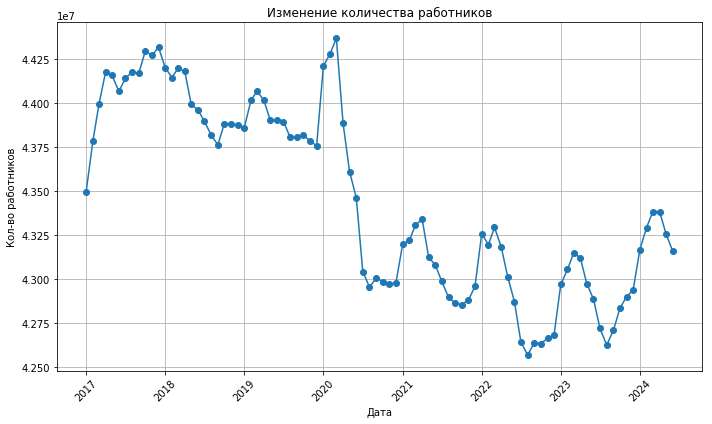

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df_fot['report_dt'], df_fot['Value'], marker='o')

plt.title('Изменение количества работников')
plt.xlabel('Дата')
plt.ylabel('Кол-во работников')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


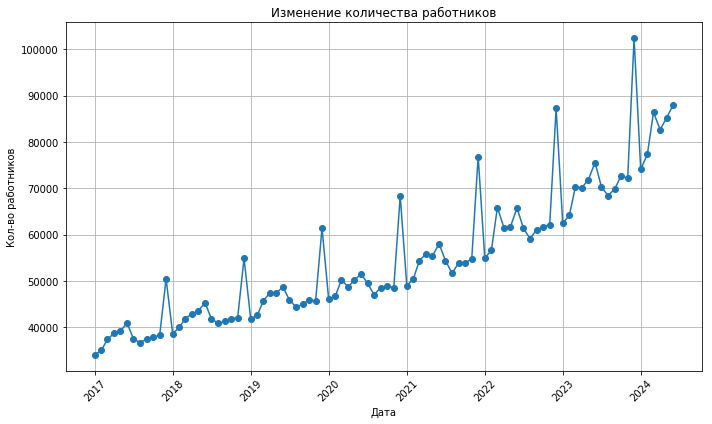

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(df_fot['report_dt'], df_fot['avg_salary'], marker='o')

plt.title('Изменение количества работников')
plt.xlabel('Дата')
plt.ylabel('Кол-во работников')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


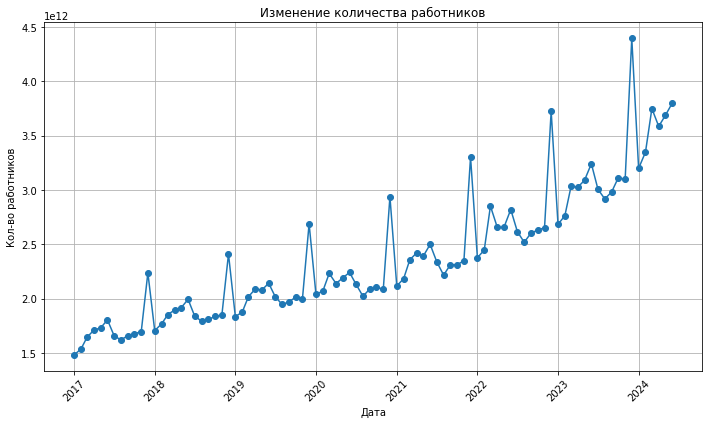

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(df_fot['report_dt'], df_fot['fot'], marker='o')

plt.title('Изменение количества работников')
plt.xlabel('Дата')
plt.ylabel('Кол-во работников')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Функции 

In [123]:
# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат
def custom_GB2(df, upper_point, num_workers, fot_true):
    
    # Накопительная доля людей в каждом бакете
    cumsum = df['cumsum'].values
    
    avg_salary = fot_true / num_workers
    
    b = avg_salary / 2
    
    upper_point = np.array(upper_point)

    # Четырехпараметрическое обобщенное бета-распределение второго типа (GB2)
    def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))

    def gb2_pdf(x, a, b, p, q):
        num = abs(a) * x**(a * p - 1)
        denom = b**(a * p) * beta(p, q) * (1 + (x  /b)**a)**(p + q)
        return num / denom
    
    def loss_b(a, b, p, q, avg_salary):
        g = (beta(p + 1/a, q - 1/a) / beta(p, q))
        loss = np.sqrt((b - avg_salary / g) ** 2)
        return loss * 1000

    # лосс-функция - RMSE(вектор реального количества людей в каждом бакете, вектор предсказанного количества людей в каждом бакете) 
    # возможно домножение на coeff_for_workers для лучшего предсказания на хвосте
    def loss_func(params):
        a, p, q = params
        # print(f'a: {a} b: {b} p: {p} q: {q}')
        y_pred = gb2_cdf(upper_point, a, b, p, q)
        # print(f'rse: {(cumsum - y_pred) * num_workers}')
        RMSE = np.sqrt(np.mean(((cumsum - y_pred) * num_workers) ** 2))
        Loss_b = loss_b(a, b, p, q, avg_salary)
        Loss = np.mean(RMSE + Loss_b)
        print(f'RMSE   = {RMSE}')
        print(f'Loss_b = {Loss_b}\n')
        return Loss

    init_params = [2, 2, 2]
    
    bounds = [(0.01, None), (0.0001, None), (0.01, None), (0.01, None)]

    result = minimize(loss_func, init_params, method='Nelder-Mead', options={'fatol' : 100.})

    a_opt, p_opt, q_opt = result.x

    print(f'a_opt = {a_opt}')
    print(f'b_opt = {b}')
    print(f'p_opt = {p_opt}')
    print(f'q_opt = {q_opt}')

    x_range = np.arange(1, 15_000_001, dtype=np.int32)
    y_pred = np.array(gb2_cdf(x_range, a_opt, b, p_opt, q_opt))

    plt.figure(figsize=(18, 6))

    plt.scatter(upper_point, df['cumsum'], color='g', edgecolor='black', label='Данные')
    plt.plot(x_range, y_pred, color='k', label='lognorm.cdf')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Доля')
    plt.title(f'Пороги вхождения в бакет')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # ----------------------------------------------------------------------------------- #
    
    pdf_from_cdf = np.array(gb2_pdf(x_range, a_opt, b, p_opt, q_opt))
    
    fot_pred = np.trapz(pdf_from_cdf * num_workers * x_range, x_range)
    
    print(f'FOT pred = {fot_pred}')
    
    print(f'Ошибка по ФОТу на биллютене = {1 - fot_pred / fot_true}')

    plt.figure(figsize=(18, 6))

    plt.plot(x_range, pdf_from_cdf * num_workers, color='k', label='weibull.pdf')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Работники')
    plt.title(f'Пороги вхождения в бакет')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    

    return a_opt, b, p_opt, q_opt



def loss_pdf_gb2_fot(df, a_start, b_start, p_start, q_start, fot_real, num_workers, avg_salary, coeff_workers, coeff_fot, upper_point, buckets):
    
    print(num_workers)
    print(avg_salary)
    print(upper_point)
    print(buckets)
    
    b = avg_salary / 2

    # Функция распределения gb2 распределения
    def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))
    
    def gb2_pdf(x, a, b, p, q):
        num = abs(a) * x**(a*p - 1)
        denom = b**(a*p) * beta(p, q) * (1 + (x/b)**a)**(p + q)
        return num / denom
    
    def loss_b(a, b, p, q, avg_salary):
        g = (beta(p + 1/a, q - 1/a) / beta(p, q))
        loss = np.sqrt((b - avg_salary / g) ** 2)
        return loss * 100_000

    # Лосс функция для калибровки a, b, p, q в разрезе месяца
    def loss_func_pdf_throw_cdf(params, avg_salary):
        a, p, q = params
        print(f'a: {a} b: {b} p: {p} q: {q}')
        math_ozhid_zp = b * (beta(p + 1/a, q - 1/a) / beta(p, q))
        print(f'math_ozhid : {math_ozhid_zp}\nreal_salar : {avg_salary}')
        
        workers_in_buckets = df['Кол-во'].values
        fot_in_buckets = df['fot'].values
        avg_salaries = df['Ср зп'].values
        
        FOT_RMSE = []
        workers_MSE = []
        avg_salary_MSE = []
        
        for (start, end), worker, fot_bucket, avg_salary in zip(buckets, workers_in_buckets, fot_in_buckets, avg_salaries):
            bucket_range = np.linspace(start, end, num=1_000_000, dtype=np.float64)
            
            pdf_from_cdf = gb2_pdf(bucket_range, a, b, p, q)
            
            fot_pred = np.trapz(pdf_from_cdf * num_workers * bucket_range, bucket_range)  
            
            num_workers_pred = np.trapz(pdf_from_cdf * num_workers, bucket_range)
            
            avg_salary_pred = fot_pred / (num_workers_pred + 0.001)
            
            workers_MSE.append((num_workers_pred - worker)**2)
            
            FOT_RMSE.append((fot_pred - fot_bucket)**2)
            
            avg_salary_MSE.append((avg_salary_pred - avg_salary)**2)
        
        workers_MSE = workers_MSE 
        FOT_RMSE = FOT_RMSE 
        avg_salary_MSE = avg_salary_MSE 
        
        Loss_b = loss_b(a, b, p, q, avg_salary)
        
        # print(f'detailed workers_MSE: {[workers_MSE]}')
        # print(f'detailed FOT_RMSE:    {FOT_RMSE}')
        # print(f'detailed avg_salary_MSE: {avg_salary_MSE}\n')
        
        workers_MSE = np.mean(workers_MSE) * 100
        FOT_RMSE = np.sqrt(np.mean(FOT_RMSE)) * 100
        avg_salary_MSE = np.mean(avg_salary_MSE)
        
        print(f'Loss_b:         {Loss_b}')
        print(f'workers_MSE:    {workers_MSE}')
        print(f'FOT_RMSE:       {FOT_RMSE}')
        print(f'avg_salary_MSE: {avg_salary_MSE}\n')
        
        loss = np.mean([workers_MSE, FOT_RMSE, Loss_b])
            
        return loss    
    # ----------------------------------------------------------------

    print(f'a_start = {a_start}')
    print(f'b_start = {b_start}')
    print(f'p_start = {p_start}')
    print(f'q_start = {q_start}')

    x_range = np.arange(1, 15_000_001, dtype=np.int32)
    y_pred_cdf = gb2_cdf(x_range, a_start, b_start, p_start, q_start)
    
    plt.figure(figsize=(18, 6))

    plt.scatter(upper_point, df['cumsum'], color='g', edgecolor='black', label='Данные')
    plt.plot(x_range, y_pred_cdf, color='k', label='lognorm.cdf')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Доля')
    plt.title(f'CDF START')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # --------------------------------------------------------------
    
    pdf_range = np.arange(1, 15_000_001, dtype=np.int32)
    
    bounds = [(a_start - 3, a_start + 3), (b_start - 3, b_start + 3),
              (p_start - 1, p_start + 1), (q_start - 1, q_start + 1)]
    
    result_new = minimize(loss_func_pdf_throw_cdf, [a_start, p_start, q_start], avg_salary, method='Nelder-Mead', options={'fatol' : 100.})
    
    a_opt_pdf, p_opt_pdf, q_opt_pdf = result_new.x
    
    print(f'a_opt_pdf = {a_opt_pdf}')
    print(f'b_opt_pdf = {b}')
    print(f'p_opt_pdf = {p_opt_pdf}')
    print(f'q_opt_pdf = {q_opt_pdf}\n')   
        
    workers_in_buckets = df['Кол-во'].values
    fot_in_buckets = df['fot'].values
    avg_salaries = df['Ср зп'].values
    
    for (start, end), worker, fot_bucket, avg_salary in zip(buckets, workers_in_buckets, fot_in_buckets, avg_salaries):
        bucket_range = np.linspace(start, end, num=3_000_000, dtype=np.float64)
        
        pdf_from_cdf = gb2_pdf(bucket_range, a_opt_pdf, b, p_opt_pdf, q_opt_pdf)
            
        fot_pred = np.trapz(pdf_from_cdf * num_workers * bucket_range, bucket_range)
        num_workers_pred = np.trapz(pdf_from_cdf * num_workers, bucket_range)
        avg_salary_pred = fot_pred / (num_workers_pred + 0.001)
        
        print(f'range: {start}-{end};\nerror fot = {(1 - fot_pred / fot_bucket) };\nerror workers = {(1 - num_workers_pred / worker)};\nerror salary = {(1 - avg_salary_pred / avg_salary)}')
        print(f'fot real: {fot_bucket}; fot_pred: {fot_pred}')
        print(f'workers:  {worker}; workers_pred: {num_workers_pred}')
        print(f'salary:   {avg_salary}; salary_pred: {avg_salary_pred}\n')
    
   
    pdf_from_cdf = gb2_pdf(pdf_range, a_opt_pdf, b, p_opt_pdf, q_opt_pdf)
    
    fot_pred = np.trapz(pdf_from_cdf * num_workers * pdf_range, pdf_range)
        
    num_workers_pred = np.trapz(pdf_from_cdf * num_workers, pdf_range)
    
    plt.figure(figsize=(18, 6))

#     # График функции плотности в людях
#     plt.plot(np.exp(pdf_range), y_new * num_workers, color='k', label='Функция плотности в людях')
    
    # График функции плотности в доле
    plt.plot(pdf_range, pdf_from_cdf * num_workers, color='k', label='Функция плотности в долях')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Доля')
    plt.title(f'PDF')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    print(f'real FOT = {fot_real}') 
    print(f'pred FOT = {fot_pred}') 
    print(f'ERROR = {1 - fot_real / fot_pred}') 
    
    print(f'real num_workers = {num_workers}') 
    print(f'pred num_workers = {num_workers_pred}') 
    print(f'ERROR_num_workers = {1 - num_workers / num_workers_pred}') 
    
    # -----------------------------------------------------
    
    y_cdf_new = gb2_cdf(x_range, a_opt_pdf, b, p_opt_pdf, q_opt_pdf)
    
    plt.figure(figsize=(18, 6))

    plt.scatter(upper_point, df['cumsum'], color='g', edgecolor='black', label='Данные')
    plt.plot(x_range, y_cdf_new, color='k', label='lognorm.cdf')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Доля')
    plt.title(f'CDF AFTER OPTIMIZE')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    
    return a_opt_pdf, b, p_opt_pdf, q_opt_pdf


# Выводит ФОТ, Количество сотрудников, Средняя зп в заданном диапазоне при заданных параметрах распределения
def range_stats(start, end, a, b, p, q, num_workers):
    
    print(f'\n CALCULATING {start}-{end} \n')
    
    def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))

#     print(f'a_pdf = {a_pdf}')
#     print(f'b_pdf = {b_pdf}')
#     print(f'p_pdf = {p_pdf}')
#     print(f'q_pdf = {q_pdf}')
    
    x_pdf = np.linspace(start, end, 3_000_000)
    y_cdf = gb2_cdf(x_pdf, a, b, p, q)
    
    # Выход на функцию плотности через производную функции распределения (так лучше работает + меньше зависимостей)
    pdf_from_cdf = np.diff(y_cdf) / np.diff(x_pdf)
        
    # Новый рэнж (на 1 значение меньше из за взятие производной)
    pdf_range_new = (x_pdf[:-1] + x_pdf[1:]) / 2
        
    fot_pred = np.trapz(pdf_from_cdf * num_workers * pdf_range_new, pdf_range_new)
        
    num_workers_pred = np.trapz(pdf_from_cdf * num_workers, pdf_range_new)
    
    # Расчитанная средняя зп в диапазоне
    avg_sal_pred = fot_pred / (num_workers_pred + 1)

    return fot_pred, num_workers_pred, avg_sal_pred

def calibrate_on_date(a_start, b_start, p_start, q_start, fot_real, num_workers, avg_salary):
    
    print(f'\n CALIBRATING \n')
    
    b = avg_salary / 2
    
    def loss_b(a, b, p, q, avg_salary):
        g = (beta(p + 1/a, q - 1/a) / beta(p, q))
        loss = np.sqrt((b - avg_salary / g) ** 2)
        return loss * 1000
    
    # Функция распределения gb2 распределения
    def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))
    
    def gb2_pdf(x, a, b, p, q):
        num = abs(a) * x**(a*p - 1)
        denom = b**(a*p) * beta(p, q) * (1 + (x/b)**a)**(p + q)
        return num / denom

    # Лосс функция для калибровки mu в разрезе месяца
    def loss_func_pdf_throw_cdf(params):
        
        a, p, q = params
        
        pdf_range = np.arange(1, 15_000_001, dtype=np.int32)
        
        pdf_from_cdf = gb2_pdf(pdf_range, a, b, p, q)

        fot_pred = np.trapz(pdf_from_cdf * num_workers * pdf_range, pdf_range)

        num_workers_pred = np.trapz(pdf_from_cdf * num_workers, pdf_range)

        avg_salary_pred = fot_pred / (num_workers_pred + 1)
        
        fot_rmse = np.sqrt((fot_pred - fot_real)**2)
        num_workers_mse = (num_workers_pred - num_workers)**2
        avg_salary_mse = (avg_salary_pred - avg_salary)**2 * 1_000
        
        Loss_b = loss_b(a, b, p, q, avg_salary)
        
        loss = np.mean([fot_rmse, avg_salary_mse, Loss_b])
        
        # print(f'FOT RMSE:        {fot_rmse}')
        # print(f'num_workers MSE: {num_workers_mse}')
        # print(f'avg_salary MSE : {avg_salary_mse}\n')
        
        return loss
    
    # ----------------------------------------------------------------

    print(f'a_start = {a_start}')
    print(f'b_start = {b}')
    print(f'p_start = {p_start}')
    print(f'q_start = {q_start}')
    
    # --------------------------------------------------------------
    
    pdf_range = np.arange(1, 15_000_001, dtype=np.int32)
    
    bounds = [(a_start - 3, a_start + 3), (b_start - 3, b_start + 3),
              (p_start - 0.1, p_start + 0.1), (q_start - 0.1, q_start + 0.3)]
    
    result_new = minimize(loss_func_pdf_throw_cdf, [a_start, p_start, q_start], method='Nelder-Mead', options={'fatol' : 100.})
    
    a_opt_new, p_opt_new, q_opt_new = result_new.x
    
    print(f'a_opt_new = {a_opt_new}')
    print(f'b_opt_new = {b}')
    print(f'p_opt_new = {p_opt_new}')
    print(f'q_opt_new = {q_opt_new}')
    
    pdf_from_cdf = gb2_pdf(pdf_range, a_opt_new, b, p_opt_new, q_opt_new)

    fot_pred = np.trapz(pdf_from_cdf * pdf_range * num_workers, pdf_range)
    
    num_workers_pred = np.trapz(pdf_from_cdf * num_workers, pdf_range)
    
    pred_avg_salary = fot_pred / num_workers_pred
    
    print(f'real FOT = {fot_real}') 
    print(f'pred FOT = {fot_pred}') 
    print(f'ERROR = {1 - fot_real / fot_pred}') 
    
    print(f'real num_workers = {num_workers}') 
    print(f'pred num_workers = {num_workers_pred}') 
    print(f'ERROR_num_workers = {1 - num_workers / num_workers_pred}')   
    
    print(f'real avg_salary = {avg_salary}') 
    print(f'pred avg_salary = {pred_avg_salary}') 
    print(f'ERROR_avg_salary = {1 - avg_salary / pred_avg_salary}')   
    
    return a_opt_new, b, p_opt_new, q_opt_new 


# Функция для парсинга бакетов
def parse_buckets(df, col_name='Бакет'):
    
    def parse_bucket(value):
        value = value.lower().replace(',', '.').strip()

        # Для первой строки 
        if value.startswith('до'):
            left = 2
            right = float(value.split("до")[1].strip())
        # Для последней строки    
        elif value.startswith('свыше'):
            left = float(value.split("свыше")[1].strip())
            right = 15_000_000
        # Обычный случай "от value до value"  
        else:
            parts = value.replace('от ', '').replace(' до', '-').split('-')
            left, right = map(float, parts)
            
        return (left, right)
    
    return df[col_name].apply(parse_bucket).tolist()

# Функция для парсинга верхних границ (на вход принимает список кортежей из функции выше)
def get_upper_bounds(ranges):
    return np.array([right for _, right in ranges])

## CDF оптимизация 

In [26]:
result = []

In [ ]:
a_opt = 1.6597126874996602
b_opt = 36996.16603875239
p_opt = 2.6259779250478235
q_opt = 1.6039456804527186

In [ ]:
a_opt = 1.480135014693831
b_opt = 34311.005759034946
p_opt = 3.317751598919772
q_opt = 1.9117519009027952

RMSE   = 4761937.35928131
Loss_b = 25286527.713143915

RMSE   = 4790649.607029524
Loss_b = 26245846.936640855

RMSE   = 4340483.568489492
Loss_b = 23629958.775356304

RMSE   = 5199697.824742754
Loss_b = 27621632.693713415

RMSE   = 4054396.08654221
Loss_b = 22528763.872111436

RMSE   = 3476140.3129526083
Loss_b = 20017341.455027606

RMSE   = 3579868.4228780847
Loss_b = 19559188.96099919

RMSE   = 2957674.1780140344
Loss_b = 16039328.395357478

RMSE   = 2456966.8543930943
Loss_b = 14912649.196921397

RMSE   = 1368597.0588663758
Loss_b = 10035462.993916102

RMSE   = 828726.2775389107
Loss_b = 6854316.893688607

RMSE   = 1199208.8231676733
Loss_b = 2163909.0829300038

RMSE   = 1358701.1537723027
Loss_b = 4289622.507610952

RMSE   = 3561789.7750574294
Loss_b = 14304762.68770851

RMSE   = 2032191.9939407697
Loss_b = 6069727.055118521

RMSE   = 4295435.725645215
Loss_b = 21386096.850247752

RMSE   = 429808.5420822453
Loss_b = 3191590.1764452937

RMSE   = 422524.4582050251
Loss_b = 3976948.08

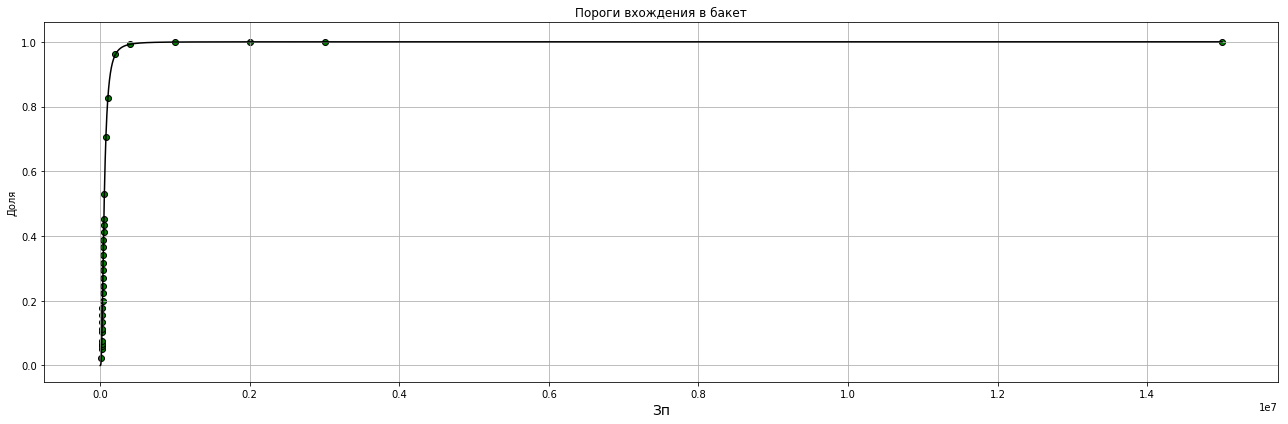

FOT pred = 2037049288807.6306
Ошибка по ФОТу на биллютене = 0.0002437974761571038


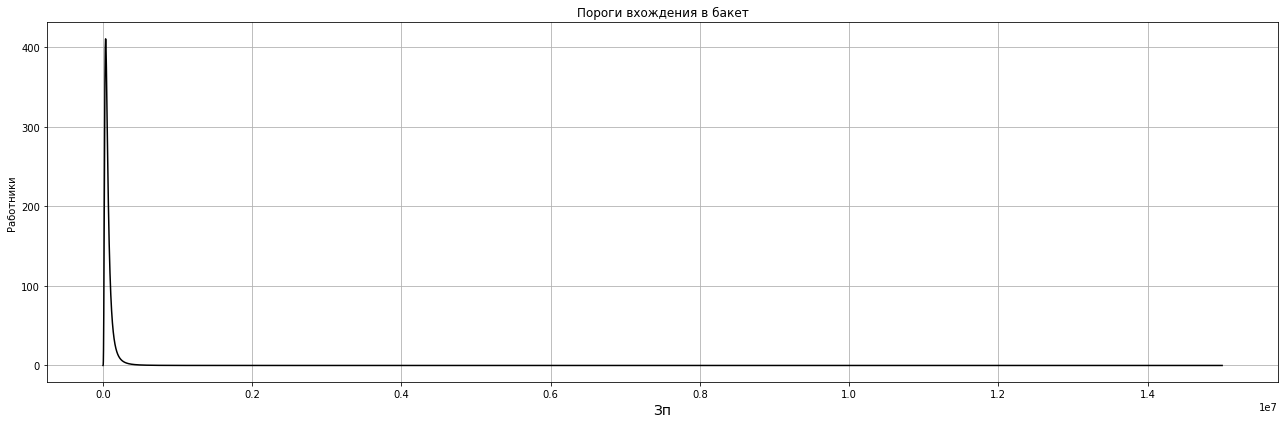

In [61]:
gc.collect()

# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат за 2023
a_cdf_2023, b_cdf_2023, p_cdf_2023, q_cdf_2023 = custom_GB2(df_2023, upper_point_2023, num_workers_2023_bill, fot_2023_bill)

result.append({
    'year' : '2023',
    'a_cdf' : a_cdf_2023, 
    'b_cdf' : b_cdf_2023, 
    'p_cdf' : p_cdf_2023, 
    'q_cdf' : q_cdf_2023
})

RMSE   = 4138650.1051409384
Loss_b = 19632052.6446517

RMSE   = 4159533.211867602
Loss_b = 20376852.63112548

RMSE   = 3768700.2695055096
Loss_b = 18345919.21561485

RMSE   = 4522917.457270613
Loss_b = 21444990.523247816

RMSE   = 3519306.088332787
Loss_b = 17490969.237596005

RMSE   = 3019906.5141113787
Loss_b = 15541141.342502294

RMSE   = 3101087.8619277827
Loss_b = 15185439.128893541

RMSE   = 2548195.242443391
Loss_b = 12452676.105420284

RMSE   = 2131733.313717519
Loss_b = 11577940.531273667

RMSE   = 1211124.7063772015
Loss_b = 7791371.755150311

RMSE   = 745295.601306787
Loss_b = 5321581.184516447

RMSE   = 1232500.9334108885
Loss_b = 1680024.142351489

RMSE   = 1399209.436710517
Loss_b = 3330393.791130391

RMSE   = 3499448.518570206
Loss_b = 11105987.241117597

RMSE   = 2004547.8739637218
Loss_b = 4712438.276877915

RMSE   = 4333461.84260351
Loss_b = 16603820.974970978

RMSE   = 532367.8921193612
Loss_b = 2477899.183111564

RMSE   = 380770.2941544149
Loss_b = 3087638.404745474

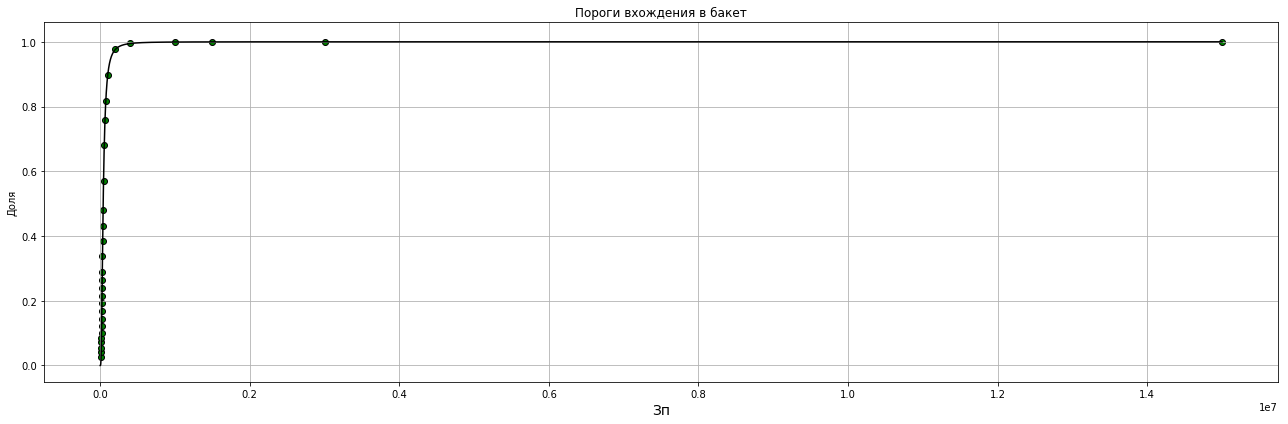

FOT pred = 1547118193326.9167
Ошибка по ФОТу на биллютене = 0.0008786403623793904


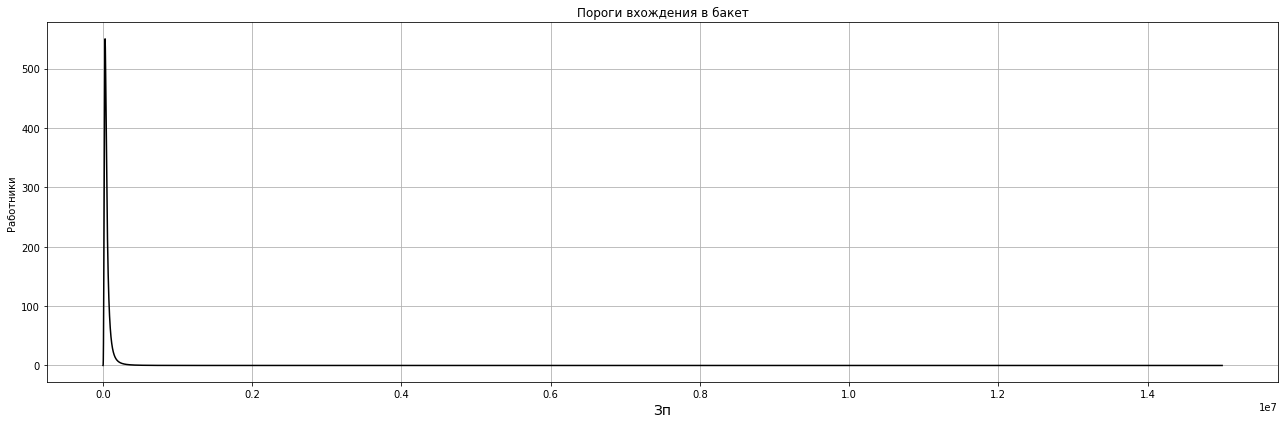

In [62]:
gc.collect()

# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат за 2021
a_cdf_2021, b_cdf_2021, p_cdf_2021, q_cdf_2021 = custom_GB2(df_2021, upper_point_2021, num_workers_2021_bill, fot_2021_bill)

result.append({
    'year' : '2021',
    'a_cdf' : a_cdf_2021, 
    'b_cdf' : b_cdf_2021, 
    'p_cdf' : p_cdf_2021, 
    'q_cdf' : q_cdf_2021
})

RMSE   = 4402997.539532403
Loss_b = 16624192.69053273

RMSE   = 4441521.222493904
Loss_b = 17254880.61273629

RMSE   = 4032092.042212461
Loss_b = 15535109.937086217

RMSE   = 4797565.279534909
Loss_b = 18159367.293783292

RMSE   = 3782644.682417143
Loss_b = 14811148.289641056

RMSE   = 3273684.072526041
Loss_b = 13160056.820596725

RMSE   = 3339300.088740608
Loss_b = 12858852.344095295

RMSE   = 2759640.009124785
Loss_b = 10544780.560462492

RMSE   = 2347308.338935501
Loss_b = 9804064.70150015

RMSE   = 1383535.3864977765
Loss_b = 6597642.52498982

RMSE   = 877561.5529334953
Loss_b = 4506252.74040387

RMSE   = 1195684.212638243
Loss_b = 1422624.805094274

RMSE   = 1380571.3918963757
Loss_b = 2820138.5316775995

RMSE   = 3603393.597868213
Loss_b = 9404420.17229587

RMSE   = 2008980.4005374452
Loss_b = 3990437.646794031

RMSE   = 4506741.543604267
Loss_b = 14059921.511173371

RMSE   = 534620.8234231456
Loss_b = 2098256.0628464087

RMSE   = 466131.00557456777
Loss_b = 2614576.1081769196



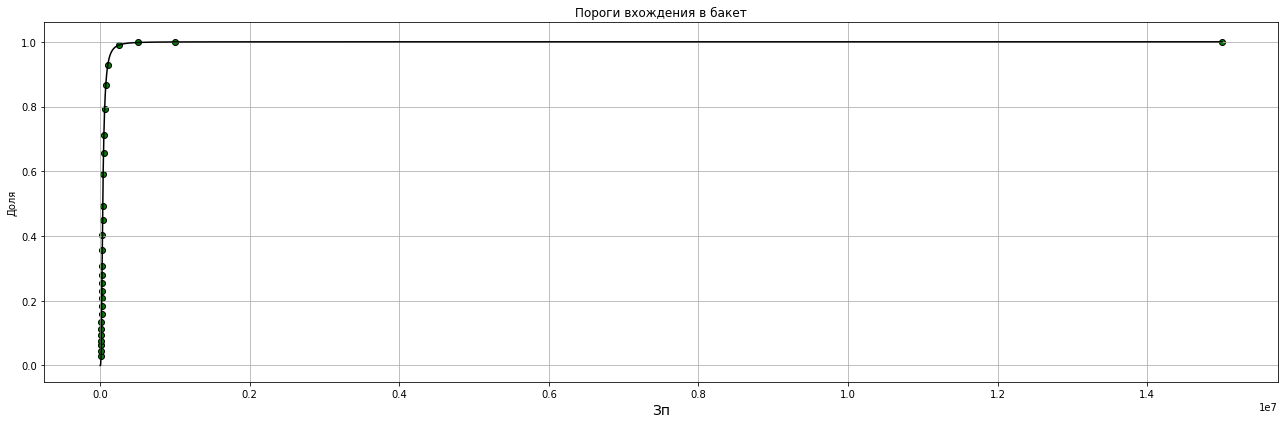

FOT pred = 1290390051594.3474
Ошибка по ФОТу на биллютене = 0.0006213199286408955


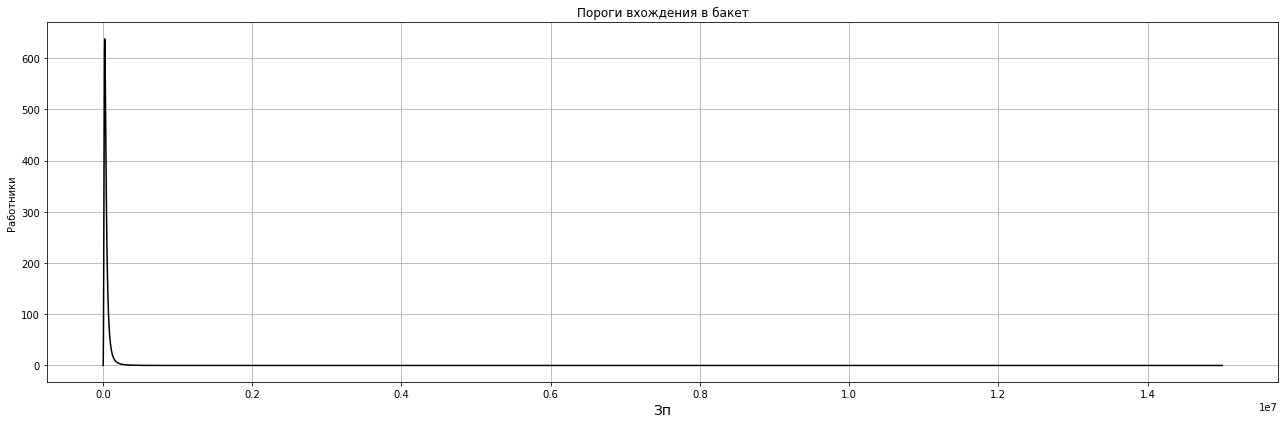

In [63]:
# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат за 2019
a_cdf_2019, b_cdf_2019, p_cdf_2019, q_cdf_2019 = custom_GB2(df_2019, upper_point_2019, num_workers_2019_bill, fot_2019_bill)

result.append({
    'year' : '2019',
    'a_cdf' : a_cdf_2019, 
    'b_cdf' : b_cdf_2019, 
    'p_cdf' : p_cdf_2019, 
    'q_cdf' : q_cdf_2019
})

RMSE   = 3919765.941042383
Loss_b = 13569240.647838943

RMSE   = 3987504.504754417
Loss_b = 14084029.928099098

RMSE   = 3630615.7842681473
Loss_b = 12680293.663042335

RMSE   = 4250084.812836761
Loss_b = 14822303.21849963

RMSE   = 3439918.3668044293
Loss_b = 12089371.14446592

RMSE   = 3034238.731380417
Loss_b = 10741693.221566526

RMSE   = 3038327.5910120043
Loss_b = 10495839.71746332

RMSE   = 2525806.239275002
Loss_b = 8607014.347533062

RMSE   = 2247427.8968178327
Loss_b = 8002416.462448716

RMSE   = 1472536.306212042
Loss_b = 5385223.859982441

RMSE   = 1040660.2946632899
Loss_b = 3678159.234123046

RMSE   = 1170542.3995954604
Loss_b = 1161195.5354019993

RMSE   = 1330981.3639139105
Loss_b = 2301894.5406214623

RMSE   = 3433012.712506963
Loss_b = 7676212.784994146

RMSE   = 1882623.6074551516
Loss_b = 3257133.126854365

RMSE   = 4449672.327258032
Loss_b = 11476193.883597549

RMSE   = 753303.6585446601
Loss_b = 1712669.1194913946

RMSE   = 671796.1461416453
Loss_b = 2134107.38580

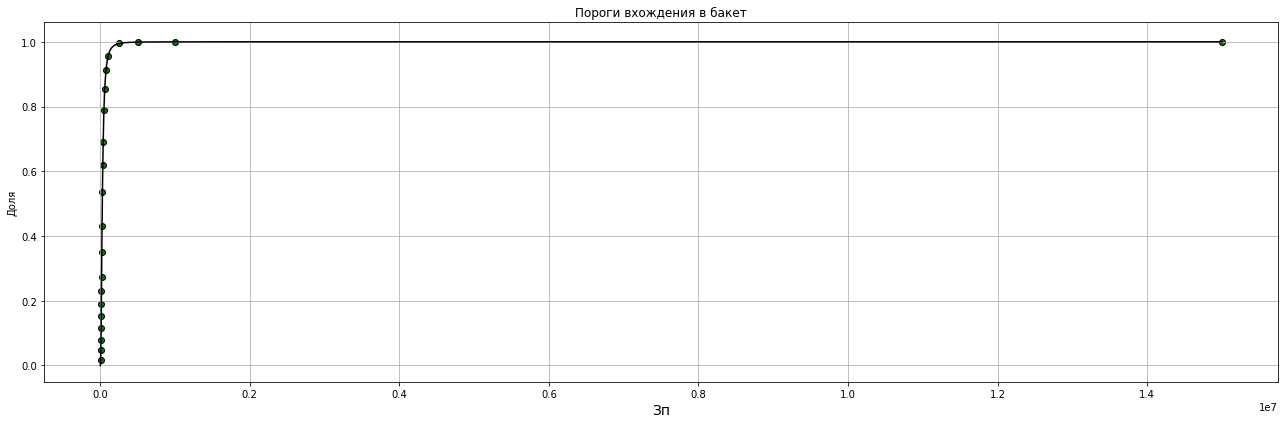

FOT pred = 1050782107971.9563
Ошибка по ФОТу на биллютене = 9.138215866855148e-05


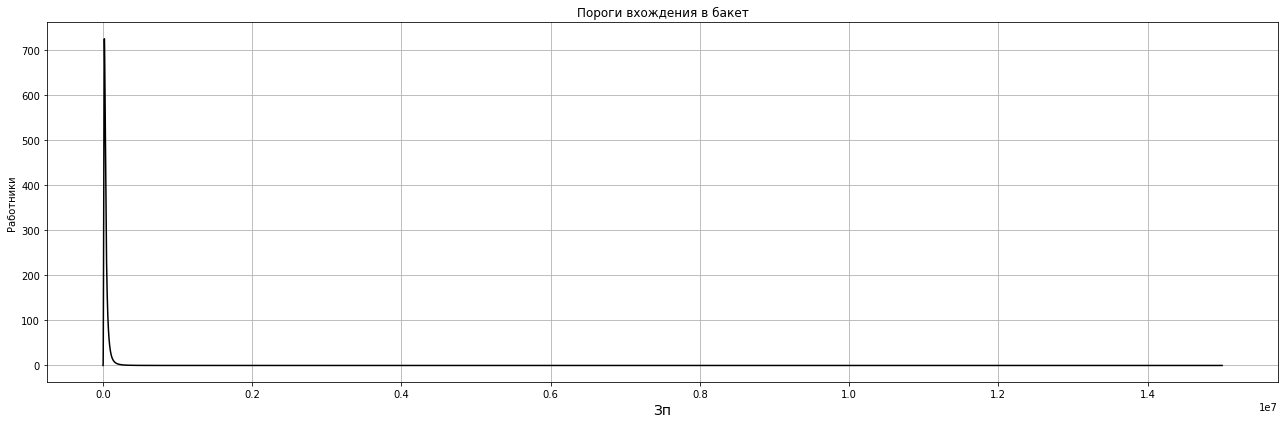

In [64]:
# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат за 2017
a_cdf_2017, b_cdf_2017, p_cdf_2017, q_cdf_2017 = custom_GB2(df_2017, upper_point_2017, num_workers_2017_bill, fot_2017_bill)

result.append({
    'year' : '2017',
    'a_cdf' : a_cdf_2017, 
    'b_cdf' : b_cdf_2017, 
    'p_cdf' : p_cdf_2017, 
    'q_cdf' : q_cdf_2017
})

RMSE   = 4343413.6212428985
Loss_b = 11790339.597725986

RMSE   = 4426569.947692961
Loss_b = 12237641.004861314

RMSE   = 4032152.0595435887
Loss_b = 11017931.833198959

RMSE   = 4704028.889664327
Loss_b = 12879128.10319346

RMSE   = 3826744.14194148
Loss_b = 10504478.107174203

RMSE   = 3384183.281794169
Loss_b = 9333478.138073318

RMSE   = 3383109.5918217027
Loss_b = 9119855.550052572

RMSE   = 2821516.6363457753
Loss_b = 7478651.511429754

RMSE   = 2520581.8684755657
Loss_b = 6953315.23284097

RMSE   = 1669052.7187254766
Loss_b = 4679231.48883662

RMSE   = 1197320.0151607243
Loss_b = 3195959.71435064

RMSE   = 1249618.217099228
Loss_b = 1008965.059804821

RMSE   = 1406948.0380816173
Loss_b = 2000120.6446582472

RMSE   = 3647166.1898109755
Loss_b = 6669876.222874782

RMSE   = 1490329.1525486868
Loss_b = 4059244.640136196

RMSE   = 2247768.9048340158
Loss_b = 4419079.894258082

RMSE   = 1020334.1934699138
Loss_b = 2604231.603647302

RMSE   = 2597863.77180115
Loss_b = 4480976.251700007

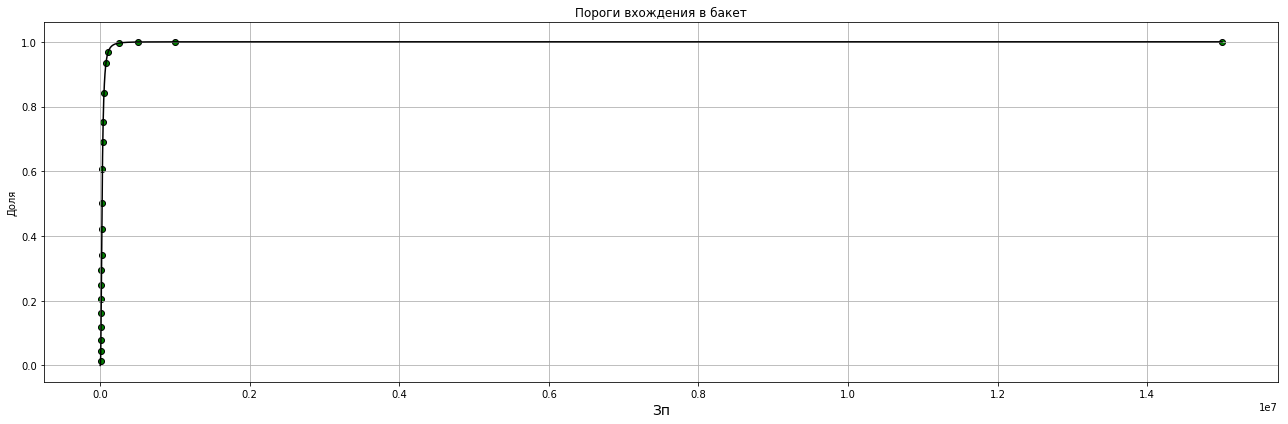

FOT pred = 978410007806.5413
Ошибка по ФОТу на биллютене = 7.553485629929746e-05


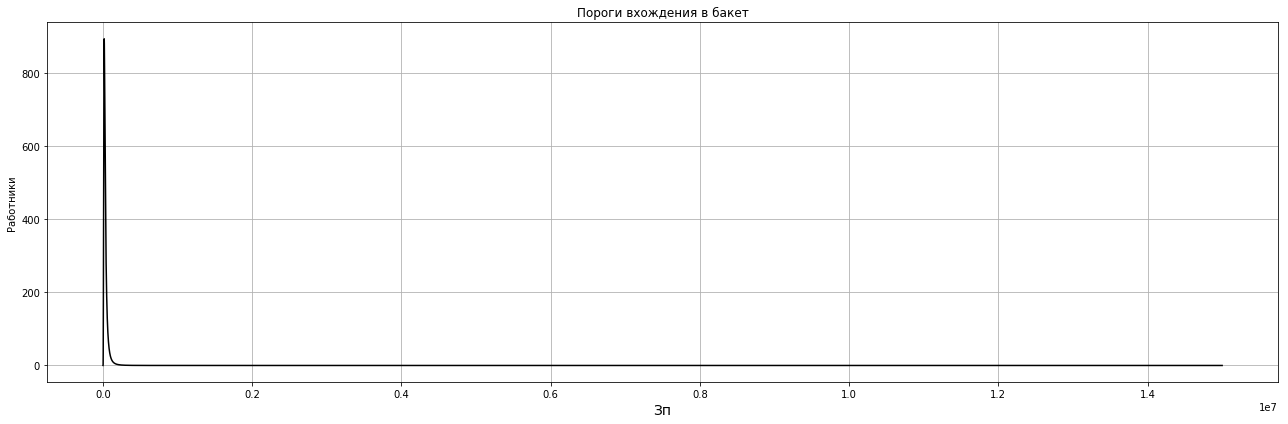

In [127]:
# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат за 2017
a_cdf_2015, b_cdf_2015, p_cdf_2015, q_cdf_2015 = custom_GB2(df_2015, upper_point_2015, num_workers_2015_bill, fot_2015_bill)

result.append({
    'year' : '2015',
    'a_cdf' : a_cdf_2015, 
    'b_cdf' : b_cdf_2015, 
    'p_cdf' : p_cdf_2015, 
    'q_cdf' : q_cdf_2015
})

In [136]:
result_df = pd.DataFrame(result)
result_df.to_excel('result_nonlog_cdf_with_fix_b.xlsx')

## Получение медианной зп по параметрам

In [69]:
# Медианная зп

def gb2_cdf(x, a, b, p, q):
    term = (x / b) ** a
    return betainc(p, q, term / (1 + term))

def obj(x, a, b, p, q):
    return abs(gb2_cdf(np.log(x), a, b, p, q) - 0.5000000)

result = minimize(obj, a_cdf_2023, b_cdf_2023, p_cdf_2023, q_cdf_2023, x0 = 45000, method='bfgs')

print(result.x[0])

gb2_cdf(np.log(result.x[0]), a_cdf_2023, b_cdf_2023, p_cdf_2023, q_cdf_2023)

NameError: name 'a_cdf_2023' is not defined

## Тестирование моделей обученной на CDF

In [66]:
buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2023 = []
num_workers_2023_bill = 28107843.91

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_cdf_2023, b_cdf_2023,
                                                                        p_cdf_2023, q_cdf_2023, num_workers_2023_bill)
        result_2023.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2023 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1132340133606.4, 507418803557.1, 235800886118.4, 102409556954.8, 59576972957.7], 
    'true_num_workers' : [23231070.9, 3779433, 887636, 185304, 24400],
    'true_avg_salary' : [48742.48538, 134257.9, 265650.5, 552657.5, 2441688.2]
})      
       
result_2023 = pd.DataFrame(result_2023)
result_2023_final = pd.merge(result_2023, true_2023, on='bucket')
result_2023_final['fot_error'] = 1 - result_2023_final['fot'] / result_2023_final['true_fot']
result_2023_final['num_workers_error'] = 1 - result_2023_final['num_workers'] / result_2023_final['true_num_workers']
result_2023_final['avg_salary_error'] = 1 - result_2023_final['avg_salary'] / result_2023_final['true_avg_salary']
# result_2023_final.to_excel('result_2023_final.xlsx')
result_2023_final


 CALCULATING 1-100000 


 CALCULATING 100000.1-200000 


 CALCULATING 200000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,1.116992e+12,2.298967e+07,4.858667e+04,1.132340e+12,23231070.9,4.874249e+04,0.013555,0.010391,0.003197
1,100000.1-200000,5.317235e+11,3.966526e+06,1.340527e+05,5.074188e+11,3779433.0,1.342579e+05,-0.047899,-0.049503,0.001529
2,200000.1-400000,2.468607e+11,9.369127e+05,2.634828e+05,2.358009e+11,887636.0,2.656505e+05,-0.046903,-0.055515,0.008160
3,400000.1-1000000,1.072588e+11,1.935516e+05,5.541586e+05,1.024096e+11,185304.0,5.526575e+05,-0.047352,-0.044509,-0.002716
4,1000000-15000001,3.421257e+10,2.114324e+04,1.618057e+06,5.957697e+10,24400.0,2.441688e+06,0.425742,0.133474,0.337321


In [68]:
buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2021 = []

num_workers_2021_bill = 27513690

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_cdf_2021, b_cdf_2021, p_cdf_2021, q_cdf_2021, num_workers_2021_bill)
        result_2021.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2021 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1019722032699, 297162900607.2, 132787959244.4, 56637829332.3, 42168571452], 
    'true_num_workers' : [24676470, 2217132, 501879, 101106, 17103],
    'true_avg_salary' : [41323.65822, 134257.9, 264581.8, 560185.0, 2465506.671]
})      
       
result_2021 = pd.DataFrame(result_2021)
result_2021_final = pd.merge(result_2021, true_2021, on='bucket')
result_2021_final['fot_error'] = 1 - result_2021_final['fot'] / result_2021_final['true_fot']
result_2021_final['num_workers_error'] = 1 - result_2021_final['num_workers'] / result_2021_final['true_num_workers']
result_2021_final['avg_salary_error'] = 1 - result_2021_final['avg_salary'] / result_2021_final['true_avg_salary']
# result_2021_final.to_excel('result_2021_final.xlsx')
result_2021_final


 CALCULATING 1-100000 


 CALCULATING 100000.1-200000 


 CALCULATING 200000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,1.010253e+12,2.465118e+07,4.098193e+04,1.019722e+12,24676470,4.132366e+04,0.009286,0.001025,0.008270
1,100000.1-200000,2.928108e+11,2.195776e+06,1.333518e+05,2.971629e+11,2217132,1.342579e+05,0.014646,0.009632,0.006749
2,200000.1-400000,1.377985e+11,5.198135e+05,2.650918e+05,1.327880e+11,501879,2.645818e+05,-0.037734,-0.035735,-0.001927
3,400000.1-1000000,7.189241e+10,1.273816e+05,5.643819e+05,5.663783e+10,101106,5.601850e+05,-0.269336,-0.259881,-0.007492
4,1000000-15000001,3.436244e+10,1.948247e+04,1.763672e+06,4.216857e+10,17103,2.465507e+06,0.185117,-0.139126,0.284661


## Оптимизация на детальных бакетных данных

In [69]:
result = []

28107843.91
72490.3
[16242.0, 18680.0, 19490.0, 20300.0, 21110.0, 23550.0, 24360.0, 25990.0, 27610.0, 29240.0, 30860.0, 32480.0, 34110.0, 35730.0, 37360.0, 38980.0, 40600.0, 42200.0, 43900.0, 45500.0, 47100.0, 48700.0, 55000.0, 75000.0, 100000.0, 200000.0, 400000.0, 1000000.0, 2000000.0, 3000000.0, 15000000]
[(2, 16242.0), (16242.1, 18680.0), (18680.1, 19490.0), (19490.1, 20300.0), (20300.1, 21110.0), (21110.1, 23550.0), (23550.1, 24360.0), (24360.1, 25990.0), (25990.1, 27610.0), (27610.1, 29240.0), (29240.1, 30860.0), (30860.1, 32480.0), (32480.1, 34110.0), (34110.1, 35730.0), (35730.1, 37360.0), (37360.1, 38980.0), (38980.1, 40600.0), (40600.1, 42200.0), (42200.1, 43900.0), (43900.1, 45500.0), (45500.1, 47100.0), (47100.1, 48700.0), (48700.1, 55000.0), (55000.1, 75000.0), (75000.1, 100000.0), (100000.1, 200000.0), (200000.1, 400000.0), (400000.1, 1000000.0), (1000000.1, 2000000.0), (2000000.1, 3000000.0), (3000000.0, 15000000)]
a_start = 1.633311781813894
b_start = 36245.15000000048


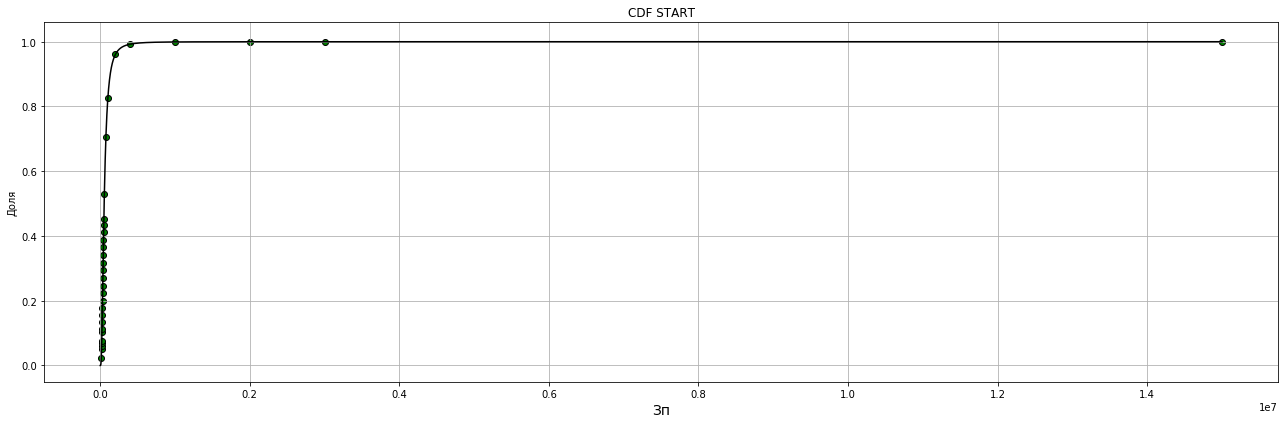

a: 1.633311781813894 b: 36245.15 p: 2.6573990349649446 q: 1.5744136784960383
math_ozhid : 72490.30039393513
real_salar : 72490.3
Loss_b:         380530302912.3818
workers_MSE:    566300229584.2686
FOT_RMSE:       656426725573.8822
avg_salary_MSE: 308268536980.8596

a: 1.7149773709045888 b: 36245.15 p: 2.6573990349649446 q: 1.5744136784960383
math_ozhid : 69115.78690855282
real_salar : 72490.3
Loss_b:         399286301671.8996
workers_MSE:    381530716257.8204
FOT_RMSE:       886693175314.1085
avg_salary_MSE: 323833506314.98206

a: 1.633311781813894 b: 36245.15 p: 2.790268986713192 q: 1.5744136784960383
math_ozhid : 74840.83253501782
real_salar : 72490.3
Loss_b:         368465121165.0739
workers_MSE:    1004636863705.0182
FOT_RMSE:       1221005704621.089
avg_salary_MSE: 308260248540.97974

a: 1.633311781813894 b: 36245.15 p: 2.6573990349649446 q: 1.6531343624208403
math_ozhid : 68533.85558178635
real_salar : 72490.3
Loss_b:         402707478316.99054
workers_MSE:    720791043038.3027
F

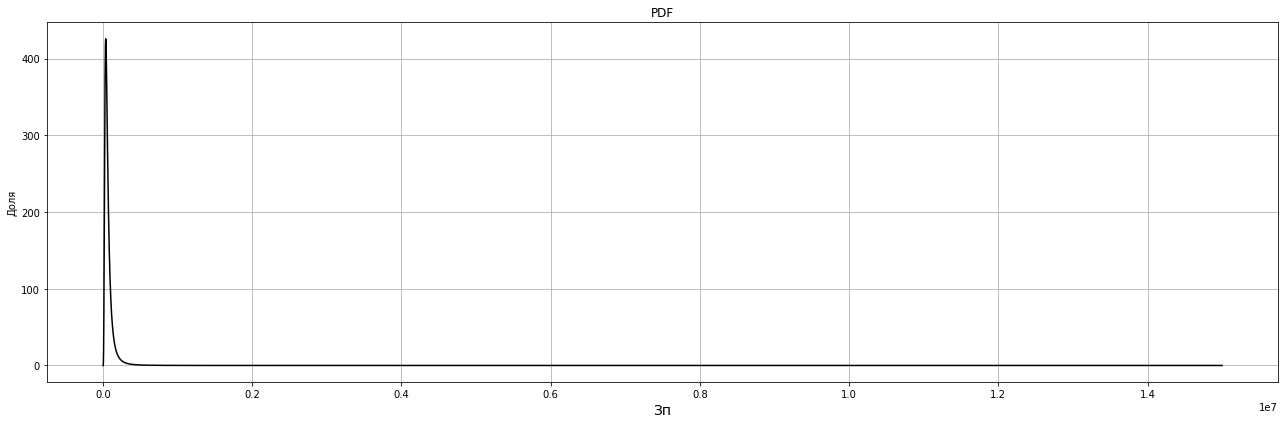

real FOT = 2037546037389.1
pred FOT = 2023140483870.9539
ERROR = -0.007120392099802864
real num_workers = 28107843.91
pred num_workers = 28107811.263541874
ERROR_num_workers = -1.1614727954967208e-06


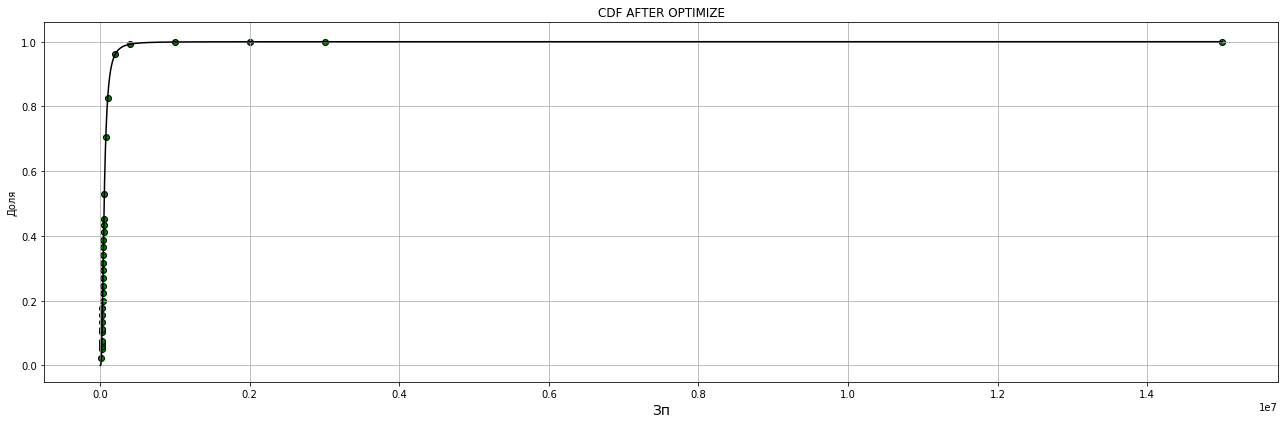

In [70]:
## Получение оптимальных параметрах на детальных бакетных данных за 2023

gc.collect()
a_pdf_2023, b_pdf_2023, p_pdf_2023, q_pdf_2023 = loss_pdf_gb2_fot(df_2023, a_cdf_2023, b_cdf_2023, p_cdf_2023, q_cdf_2023, fot_real=fot_2023_bill, 
                                 num_workers=num_workers_2023_bill, avg_salary=avg_salary_2023_bill, coeff_workers=coeff_for_workers_2023, 
                                 coeff_fot=coeff_for_fot_2023, upper_point=upper_point_2023, buckets=buckets_2023)

result.append({
    'year' : '2023',
    'a_pdf' : a_pdf_2023, 
    'b_pdf' : b_pdf_2023, 
    'p_pdf' : p_pdf_2023, 
    'q_pdf' : q_pdf_2023
})

27513690
56280.3
[12792.0, 13770.0, 14750.0, 15990.0, 16650.0, 17950.0, 19250.0, 20470.0, 21780.0, 23080.0, 24330.0, 25590.0, 26870.0, 28150.0, 30740.0, 33230.0, 35800.0, 38850.0, 45000.0, 55000.0, 65000.0, 75000.0, 100000.0, 200000.0, 400000.0, 1000000.0, 1500000.0, 3000000.0, 15000000]
[(2, 12792.0), (12792.1, 13770.0), (13770.1, 14750.0), (14750.1, 15990.0), (15990.1, 16650.0), (16650.1, 17950.0), (17950.1, 19250.0), (19250.1, 20470.0), (20470.1, 21780.0), (21780.1, 23080.0), (23080.1, 24330.0), (24330.1, 25590.0), (25590.1, 26870.0), (26870.1, 28150.0), (28150.1, 30740.0), (30740.1, 33230.0), (33230.1, 35800.0), (35800.1, 38850.0), (38850.1, 45000.0), (45000.1, 55000.0), (55000.1, 65000.0), (65000.1, 75000.0), (75000.1, 100000.0), (100000.1, 200000.0), (200000.1, 400000.0), (400000.1, 1000000.0), (1000000.1, 1500000.0), (1500000.1, 3000000.0), (3000000.0, 15000000)]
a_start = 2.1301203899078613
b_start = 28140.150398879614
p_start = 1.8490059466256366
q_start = 1.0360575815099646


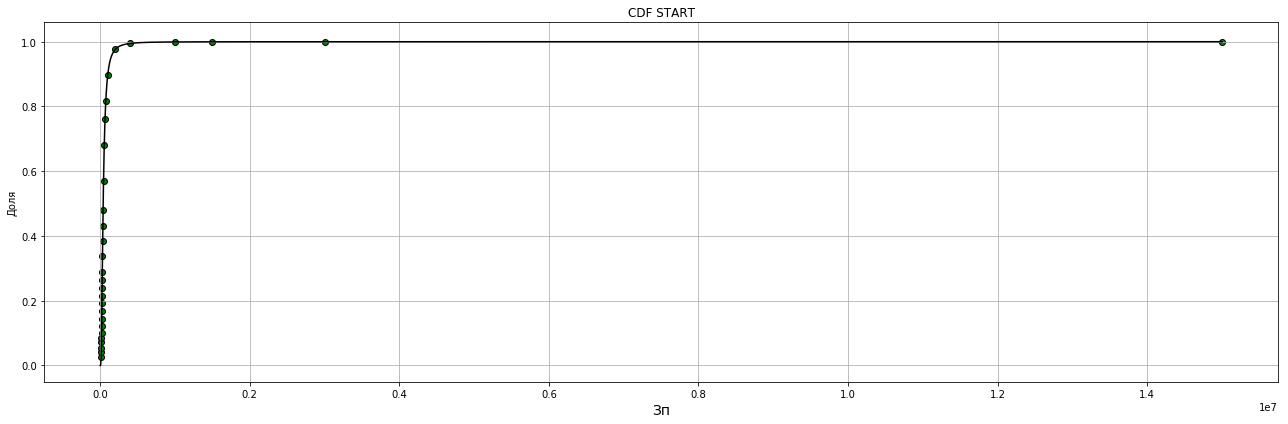

a: 2.1301203899078613 b: 28140.15 p: 1.8490059466256366 q: 1.0360575815099646
math_ozhid : 56280.30008309267
real_salar : 56280.3
Loss_b:         386151819425.7279
workers_MSE:    465801212119.61395
FOT_RMSE:       428266779980.01483
avg_salary_MSE: 298382254414.6523

a: 2.2366264094032546 b: 28140.15 p: 1.8490059466256366 q: 1.0360575815099646
math_ozhid : 53545.5838226996
real_salar : 56280.3
Loss_b:         406017345510.26105
workers_MSE:    894347644144.9877
FOT_RMSE:       872100177040.5193
avg_salary_MSE: 314814258679.6896

a: 2.1301203899078613 b: 28140.15 p: 1.9414562439569185 q: 1.0360575815099646
math_ozhid : 57765.36105660244
real_salar : 56280.3
Loss_b:         376152090000.1937
workers_MSE:    400835513943.13763
FOT_RMSE:       525588886432.1203
avg_salary_MSE: 298381771691.4862

a: 2.1301203899078613 b: 28140.15 p: 1.8490059466256366 q: 1.087860460585463
math_ozhid : 53192.06266519448
real_salar : 56280.3
Loss_b:         408734490297.4767
workers_MSE:    1015450484400.179

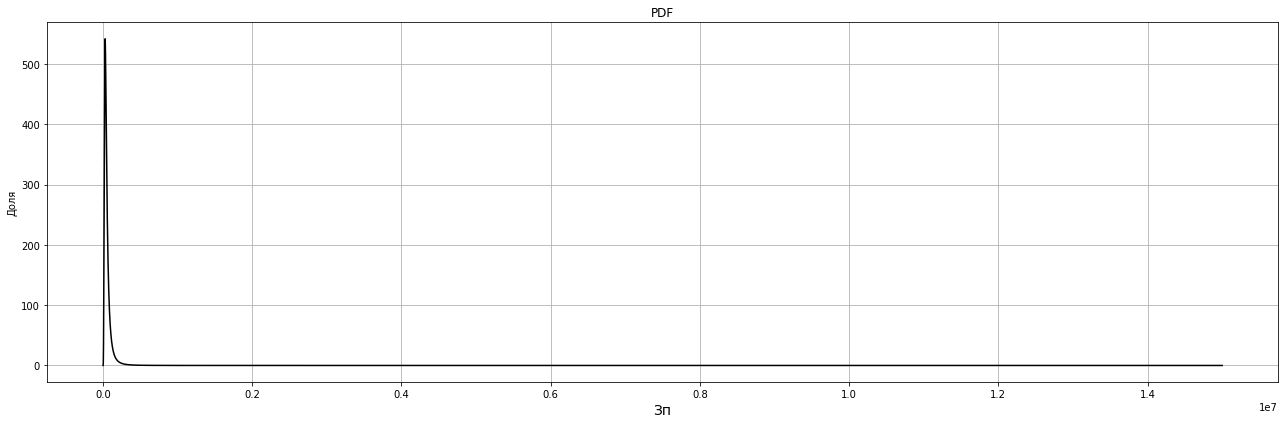

real FOT = 1548478749256.3
pred FOT = 1540733975496.3542
ERROR = -0.005026678117778793
real num_workers = 27513690
pred num_workers = 27513663.77445467
ERROR_num_workers = -9.531825913011716e-07


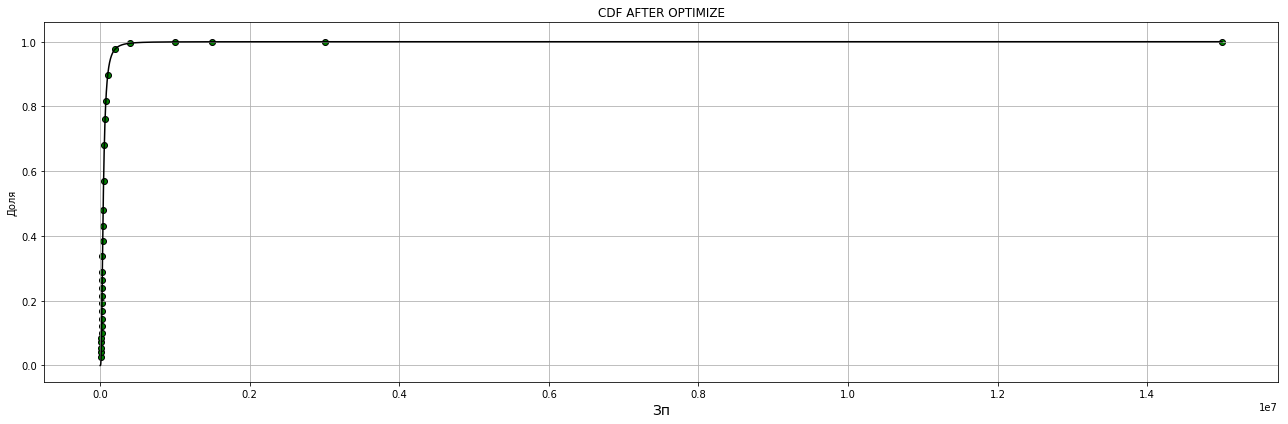

In [71]:
## Получение оптимальных параметрах на детальных бакетных данных за 2021

gc.collect()
a_pdf_2021, b_pdf_2021, p_pdf_2021, q_pdf_2021 = loss_pdf_gb2_fot(df_2021, a_cdf_2021, b_cdf_2021, p_cdf_2021, q_cdf_2021, fot_real=fot_2021_bill, 
                                 num_workers=num_workers_2021_bill, avg_salary=avg_salary_2021_bill, coeff_workers=coeff_for_workers_2021, 
                                 coeff_fot=coeff_for_fot_2021, upper_point=upper_point_2021, buckets=buckets_2021)

result.append({
    'year' : '2021',
    'a_pdf' : a_pdf_2021, 
    'b_pdf' : b_pdf_2021, 
    'p_pdf' : p_pdf_2021, 
    'q_pdf' : q_pdf_2021
})

27093160
47657.5
[11280.0, 12140.0, 13000.0, 13850.0, 14700.0, 15850.0, 17000.0, 18050.0, 19200.0, 20350.0, 21450.0, 22560.0, 23690.0, 24820.0, 27100.0, 29300.0, 31600.0, 33900.0, 40000.0, 45000.0, 50000.0, 60000.0, 75000.0, 100000.0, 250000.0, 500000.0, 1000000.0, 15000000]
[(2, 11280.0), (11280.1, 12140.0), (12140.1, 13000.0), (13000.1, 13850.0), (13850.1, 14700.0), (14700.1, 15850.0), (15850.1, 17000.0), (17000.1, 18050.0), (18050.1, 19200.0), (19200.1, 20350.0), (20350.1, 21450.0), (21450.1, 22560.0), (22560.1, 23690.0), (23690.1, 24820.0), (24820.1, 27100.0), (27100.1, 29300.0), (29300.1, 31600.0), (31600.1, 33900.0), (33900.1, 40000.0), (40000.1, 45000.0), (45000.1, 50000.0), (50000.1, 60000.0), (60000.1, 75000.0), (75000.1, 100000.0), (100000.1, 250000.0), (250000.1, 500000.0), (500000.1, 1000000.0), (1000000.0, 15000000)]
a_start = 2.1063206876240113
b_start = 23828.750413370017
p_start = 1.9050056050116553
q_start = 1.060839357195928


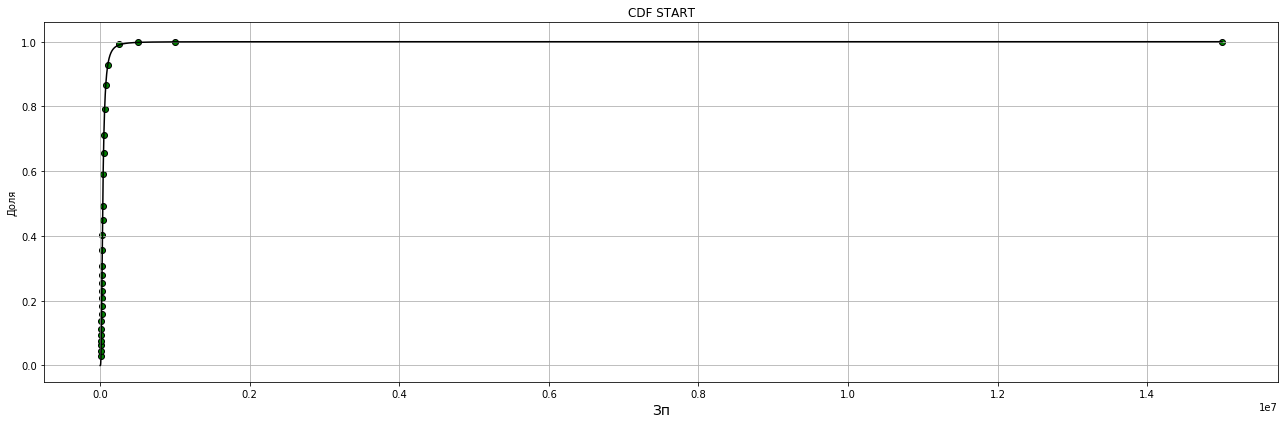

a: 2.1063206876240113 b: 23828.75 p: 1.9050056050116553 q: 1.060839357195928
math_ozhid : 47657.49982997139
real_salar : 47657.5
Loss_b:         115141790419.29506
workers_MSE:    658495218681.5684
FOT_RMSE:       353533798536.88025
avg_salary_MSE: 12859213553.742874

a: 2.211636722005212 b: 23828.75 p: 1.9050056050116553 q: 1.060839357195928
math_ozhid : 45358.56763922097
real_salar : 47657.5
Loss_b:         121098354980.34105
workers_MSE:    1184054767467.7756
FOT_RMSE:       778617772329.5935
avg_salary_MSE: 15095128320.84659

a: 2.1063206876240113 b: 23828.75 p: 2.0002558852622383 q: 1.060839357195928
math_ozhid : 48923.30321555422
real_salar : 47657.5
Loss_b:         112101048899.41469
workers_MSE:    559784612951.9633
FOT_RMSE:       438274884501.7763
avg_salary_MSE: 12858844842.811543

a: 2.1063206876240113 b: 23828.75 p: 1.9050056050116553 q: 1.1138813250557245
math_ozhid : 45065.210624336265
real_salar : 47657.5
Loss_b:         121902169819.31491
workers_MSE:    1281457254197.

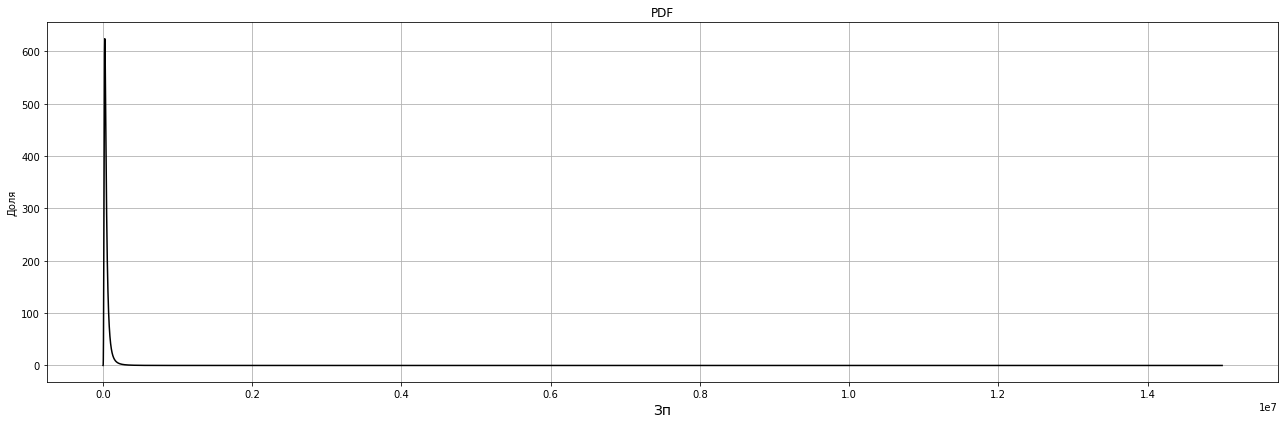

real FOT = 1291192295099.0
pred FOT = 1287157861902.6729
ERROR = -0.003134373269773949
real num_workers = 27093160
pred num_workers = 27093146.751465503
ERROR_num_workers = -4.88999473580165e-07


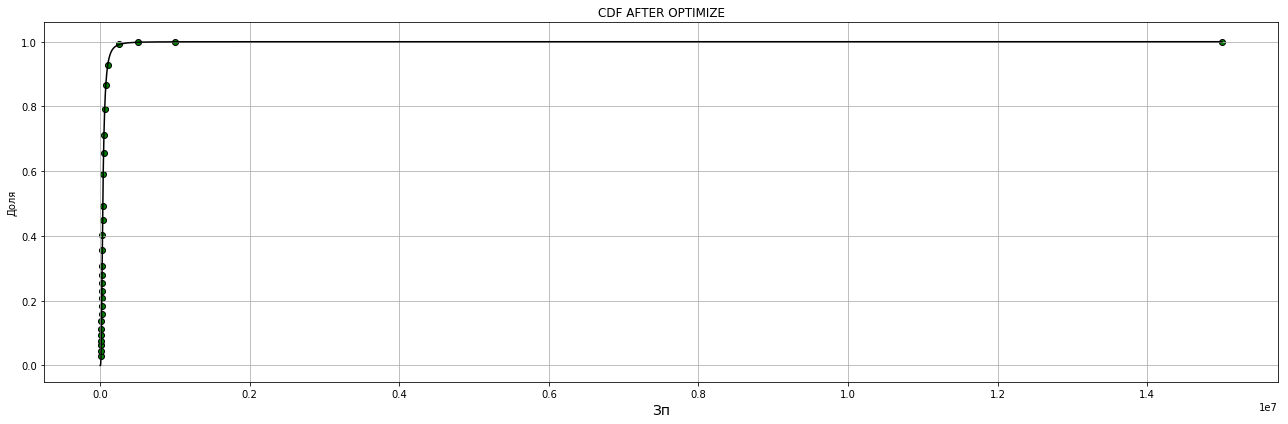

In [72]:
gc.collect()
a_pdf_2019, b_pdf_2019, p_pdf_2019, q_pdf_2019 = loss_pdf_gb2_fot(df_2019, a_cdf_2019, b_cdf_2019, p_cdf_2019, q_cdf_2019, fot_real=fot_2019_bill, 
                                 num_workers=num_workers_2019_bill, avg_salary=avg_salary_2019_bill, coeff_workers=coeff_for_workers_2019, 
                                 coeff_fot=coeff_for_fot_2019, upper_point=upper_point_2019, buckets=buckets_2019)

result.append({
    'year' : '2019',
    'a_pdf' : a_pdf_2019, 
    'b_pdf' : b_pdf_2019, 
    'p_pdf' : p_pdf_2019, 
    'q_pdf' : q_pdf_2019
})

27015071
38899.7
[7500.0, 9000.0, 10600.0, 12200.0, 13800.0, 15400.0, 17000.0, 18600.0, 21800.0, 25000.0, 30000.0, 35000.0, 40000.0, 50000.0, 60000.0, 75000.0, 100000.0, 250000.0, 500000.0, 1000000.0, 15000000]
[(2, 7500.0), (7500.1, 9000.0), (9000.1, 10600.0), (10600.1, 12200.0), (12200.1, 13800.0), (13800.1, 15400.0), (15400.1, 17000.0), (17000.1, 18600.0), (18600.1, 21800.0), (21800.1, 25000.0), (25000.1, 30000.0), (30000.1, 35000.0), (35000.1, 40000.0), (40000.1, 50000.0), (50000.1, 60000.0), (60000.1, 75000.0), (75000.1, 100000.0), (100000.1, 250000.0), (250000.1, 500000.0), (500000.1, 1000000.0), (1000000.0, 15000000)]
a_start = 1.5038169885624062
b_start = 19449.84966881708
p_start = 2.753388707892009
q_start = 1.724251073530683


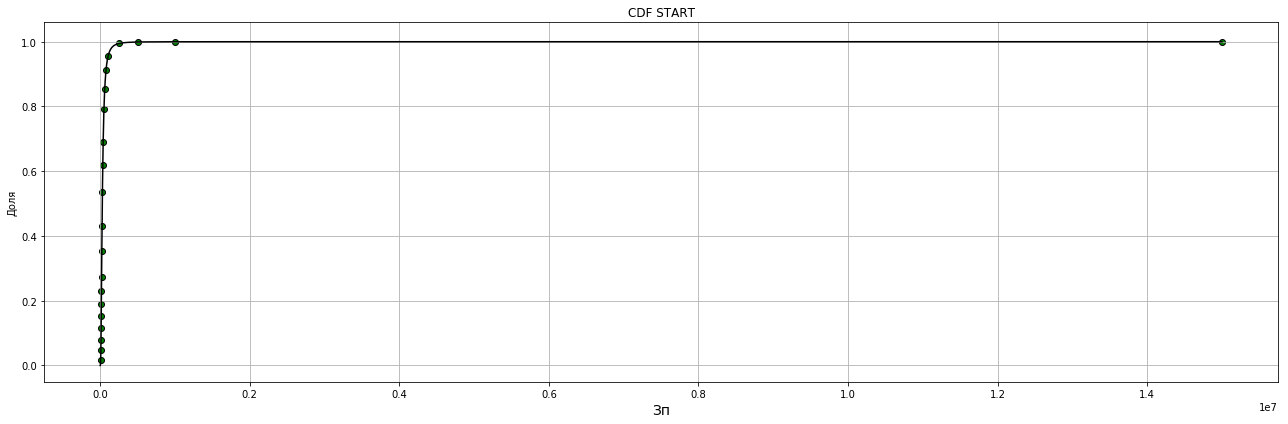

a: 1.5038169885624062 b: 19449.85 p: 2.753388707892009 q: 1.724251073530683
math_ozhid : 38899.68213078757
real_salar : 38899.7
Loss_b:         115934164149.71211
workers_MSE:    933443909833.6088
FOT_RMSE:       505377271462.43134
avg_salary_MSE: 26652874802.58942

a: 1.5790078379905266 b: 19449.85 p: 2.753388707892009 q: 1.724251073530683
math_ozhid : 37059.36872634365
real_salar : 38899.7
Loss_b:         121787868239.67014
workers_MSE:    1434185578002.624
FOT_RMSE:       544503489981.2017
avg_salary_MSE: 29694843595.42469

a: 1.5038169885624062 b: 19449.85 p: 2.89105814328661 q: 1.724251073530683
math_ozhid : 40255.99861711809
real_salar : 38899.7
Loss_b:         111962546530.50883
workers_MSE:    1098147123872.2976
FOT_RMSE:       740655629271.451
avg_salary_MSE: 26648086505.287174

a: 1.5038169885624062 b: 19449.85 p: 2.753388707892009 q: 1.8104636272072172
math_ozhid : 36680.3374237037
real_salar : 38899.7
Loss_b:         123066444933.25534
workers_MSE:    1581606089589.3728
FOT

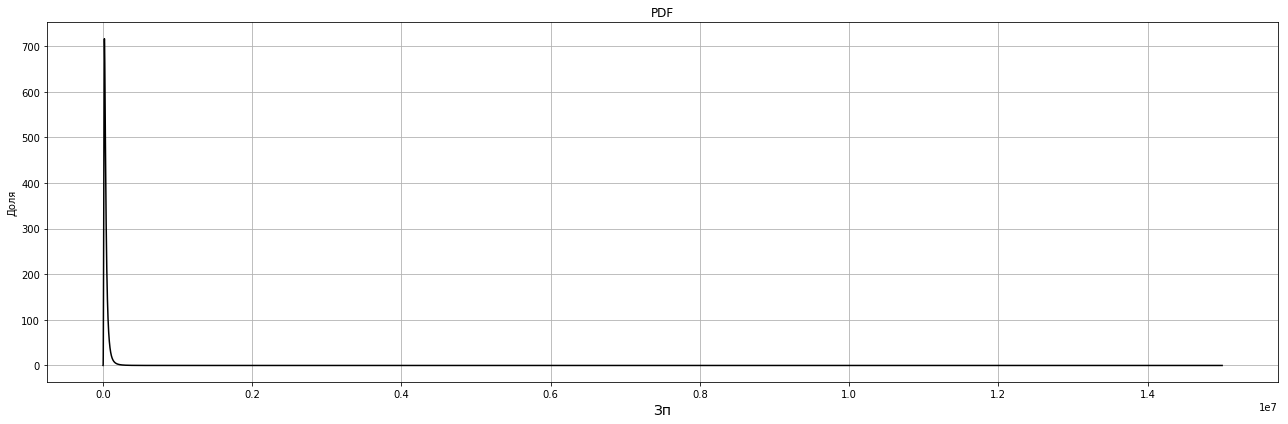

real FOT = 1050878139484.84
pred FOT = 1025218079541.9011
ERROR = -0.02502887966470957
real num_workers = 27015071
pred num_workers = 27015070.65435409
ERROR_num_workers = -1.2794558745810036e-08


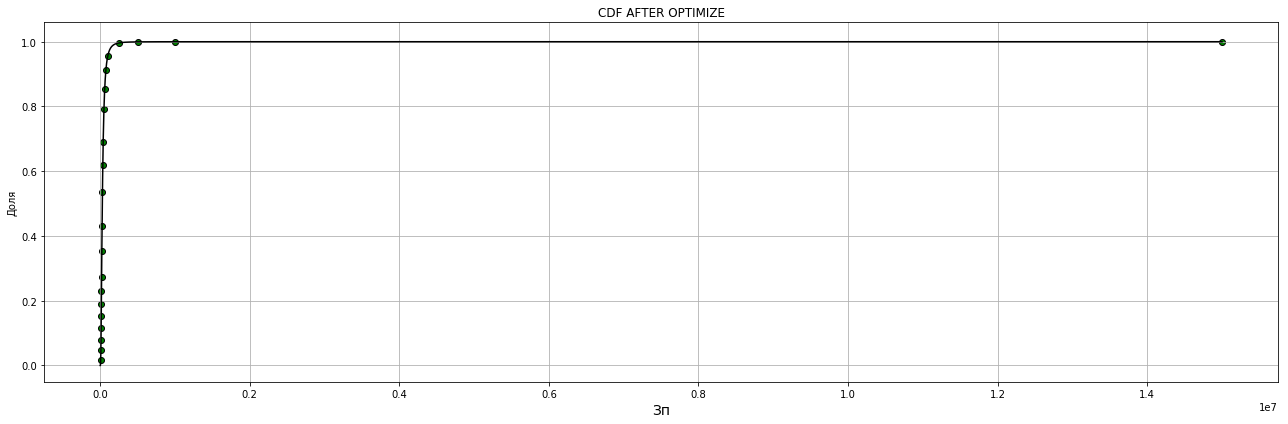

In [73]:
## Получение оптимальных параметрах на детальных бакетных данных за 2021

gc.collect()
a_pdf_2017, b_pdf_2017, p_pdf_2017, q_pdf_2017 = loss_pdf_gb2_fot(df_2017, a_cdf_2017, b_cdf_2017, p_cdf_2017, q_cdf_2017, fot_real=fot_2017_bill, 
                                 num_workers=num_workers_2017_bill, avg_salary=avg_salary_2017_bill, coeff_workers=coeff_for_workers_2017, 
                                 coeff_fot=coeff_for_fot_2017, upper_point=upper_point_2017, buckets=buckets_2017)

result.append({
    'year' : '2017',
    'a_pdf' : a_pdf_2017, 
    'b_pdf' : b_pdf_2017, 
    'p_pdf' : p_pdf_2017, 
    'q_pdf' : q_pdf_2017
})

28949207.400000006
33800.02443343705
[5.965e+03 7.400e+03 9.000e+03 1.060e+04 1.220e+04 1.380e+04 1.540e+04
 1.700e+04 1.860e+04 2.180e+04 2.500e+04 3.000e+04 3.500e+04 4.000e+04
 5.000e+04 7.500e+04 1.000e+05 2.500e+05 5.000e+05 1.000e+06 1.500e+07]
[(2, 5965.0), (5965.1, 7400.0), (7400.1, 9000.0), (9000.1, 10600.0), (10600.1, 12200.0), (12200.1, 13800.0), (13800.1, 15400.0), (15400.1, 17000.0), (17000.1, 18600.0), (18600.1, 21800.0), (21800.1, 25000.0), (25000.1, 30000.0), (30000.1, 35000.0), (35000.1, 40000.0), (40000.1, 50000.0), (50000.1, 75000.0), (75000.1, 100000.0), (100000.1, 250000.0), (250000.1, 500000.0), (500000.1, 1000000.0), (1000000.0, 15000000)]
a_start = 1.511010380114013
b_start = 16900.012216718525
p_start = 2.7352228443069873
q_start = 1.7108073701642255


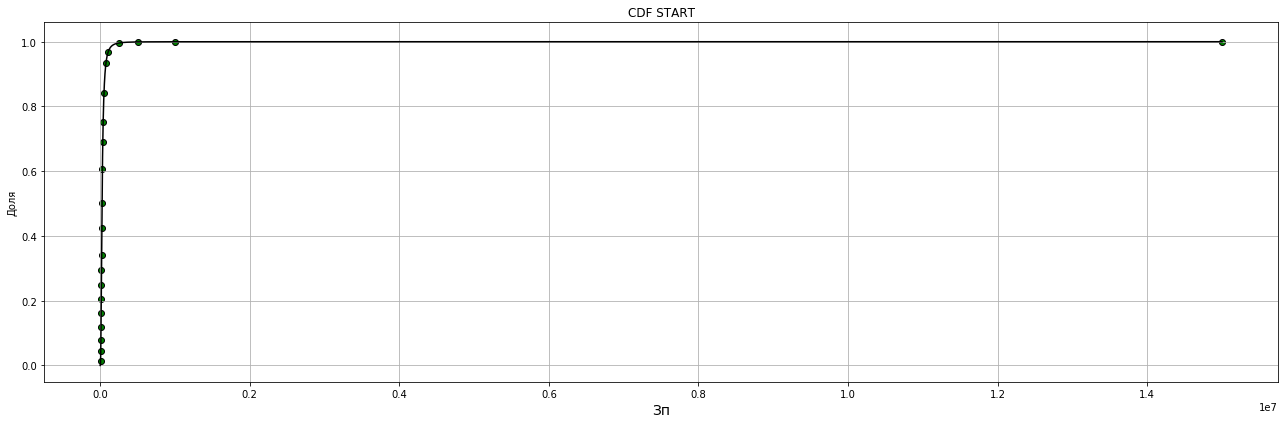

a: 1.511010380114013 b: 16900.012216718525 p: 2.7352228443069873 q: 1.7108073701642255
math_ozhid : 33800.02254638916
real_salar : 33800.02443343705
Loss_b:         111874125118.5882
workers_MSE:    1618302165532.372
FOT_RMSE:       502058397357.52985
avg_salary_MSE: 20730769071.451996

a: 1.5865608991197135 b: 16900.012216718525 p: 2.7352228443069873 q: 1.7108073701642255
math_ozhid : 32200.116214644015
real_salar : 33800.02443343705
Loss_b:         117516712355.84349
workers_MSE:    2705330968273.1455
FOT_RMSE:       572123225129.1537
avg_salary_MSE: 23428392636.85571

a: 1.511010380114013 b: 16900.012216718525 p: 2.871983986522337 q: 1.7108073701642255
math_ozhid : 34973.86877650239
real_salar : 33800.02443343705
Loss_b:         108062513013.77637
workers_MSE:    1693017846622.2307
FOT_RMSE:       654922418249.6532
avg_salary_MSE: 20727434820.864605

a: 1.511010380114013 b: 16900.012216718525 p: 2.7352228443069873 q: 1.796347738672437
math_ozhid : 31873.06497444341
real_salar : 3380

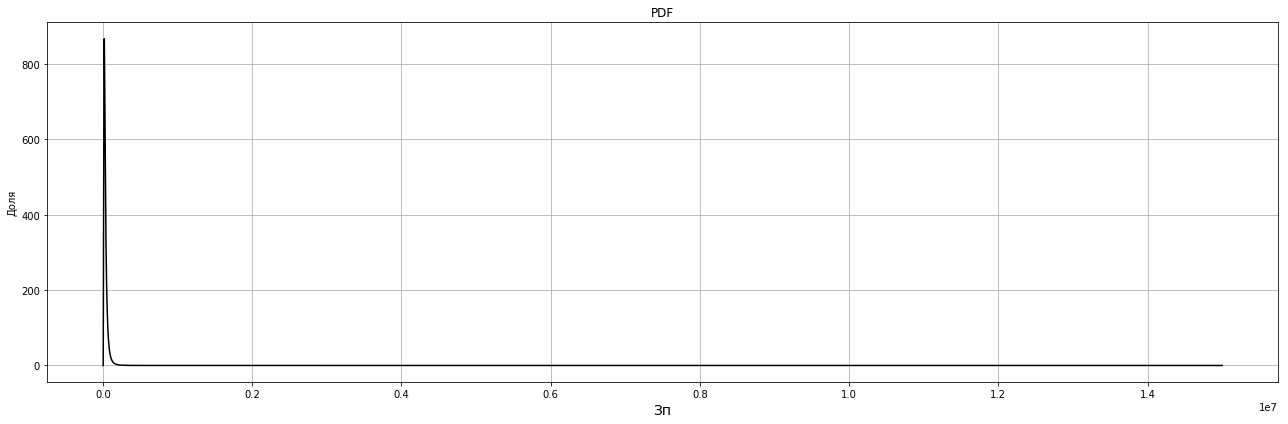

real FOT = 978483917448.637
pred FOT = 951710904987.3165
ERROR = -0.028131454962867286
real num_workers = 28949207.400000006
pred num_workers = 28949207.366354182
ERROR_num_workers = -1.1622365292396353e-09


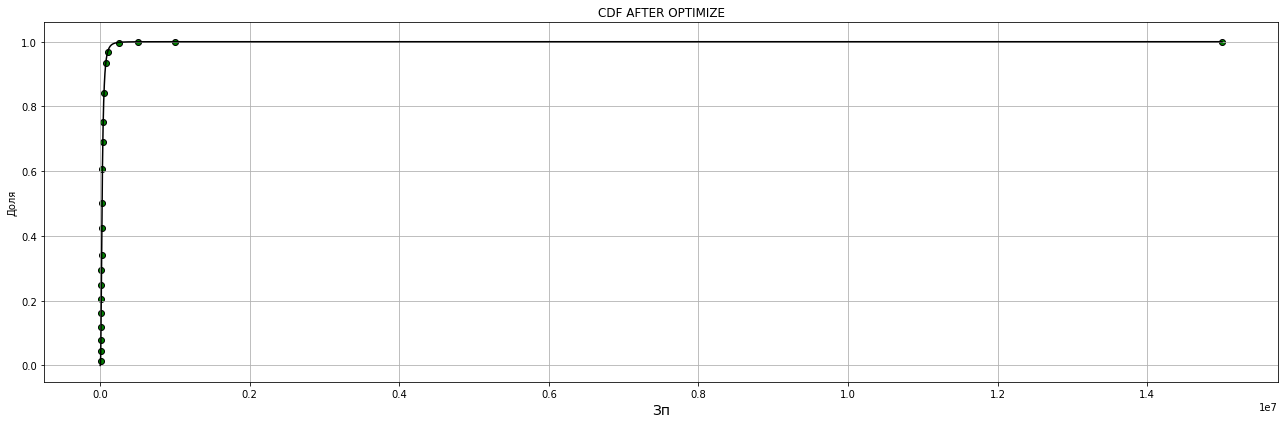

In [131]:
## Получение оптимальных параметрах на детальных бакетных данных за 2021

gc.collect()
a_pdf_2015, b_pdf_2015, p_pdf_2015, q_pdf_2015 = loss_pdf_gb2_fot(df_2015, a_cdf_2015, b_cdf_2015, p_cdf_2015, q_cdf_2015, fot_real=fot_2015_bill, 
                                 num_workers=num_workers_2015_bill, avg_salary=avg_salary_2015_bill, coeff_workers=coeff_for_workers_2015, 
                                 coeff_fot=coeff_for_fot_2015, upper_point=upper_point_2015, buckets=buckets_2015)

result.append({
    'year' : '2015',
    'a_pdf' : a_pdf_2015, 
    'b_pdf' : b_pdf_2015, 
    'p_pdf' : p_pdf_2015, 
    'q_pdf' : q_pdf_2015
})

In [134]:
result_df = pd.DataFrame(result)
result_df.to_excel('parameters_by_years_pdf_non_log_without_coeffs_with_B_fix.xlsx', index=False)

## Тестирование моделей обученных на деталке

In [32]:
parameters = pd.read_excel('parameters_by_years.xlsx')

a_pdf_2023, b_pdf_2023, p_pdf_2023, q_pdf_2023 = parameters[parameters['year'] == 2023][['a_pdf', 'b_pdf', 'p_pdf', 'q_pdf']].values.T

a_pdf_2021, b_pdf_2021, p_pdf_2021, q_pdf_2021 = parameters[parameters['year'] == 2021][['a_pdf', 'b_pdf', 'p_pdf', 'q_pdf']].values.T

a_pdf_2019, b_pdf_2019, p_pdf_2019, q_pdf_2019 = parameters[parameters['year'] == 2019][['a_pdf', 'b_pdf', 'p_pdf', 'q_pdf']].values.T

a_pdf_2017, b_pdf_2017, p_pdf_2017, q_pdf_2017 = parameters[parameters['year'] == 2017][['a_pdf', 'b_pdf', 'p_pdf', 'q_pdf']].values.T

In [76]:
buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2023 = []

print(f'a :{a_pdf_2023}, b: {b_pdf_2023}, p: {p_pdf_2023}, q: {q_pdf_2023}')

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_pdf_2023, b_pdf_2023,
                                                                        p_pdf_2023, q_pdf_2023, num_workers_2023_bill)
        result_2023.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2023 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1132340133606.4, 507418803557.1, 235800886118.4, 102409556954.8, 59576972957.7], 
    'true_num_workers' : [23231071, 3779433, 887636, 185304, 24400],
    'true_avg_salary' : [48742.48538, 134257.9, 265650.5, 552657.5, 2441688.2]
})      
       
result_2023 = pd.DataFrame(result_2023)
result_2023_final_det = pd.merge(result_2023, true_2023, on='bucket')
result_2023_final_det['fot_error'] = 1 - result_2023_final_det['fot'] / result_2023_final_det['true_fot']
result_2023_final_det['num_workers_error'] = 1 - result_2023_final_det['num_workers'] / result_2023_final_det['true_num_workers']
result_2023_final_det['avg_salary_error'] = 1 - result_2023_final_det['avg_salary'] / result_2023_final_det['true_avg_salary']
# result_2023_final_det.to_excel('result_2023_final_det_nonlog.xlsx')
result_2023_final_det

a :1.883881805692282, b: 36245.15, p: 2.2989098818980533, q: 1.2919585948589247

 CALCULATING 1-100000 


 CALCULATING 100000.1-200000 


 CALCULATING 200000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,1.133768e+12,2.320446e+07,4.885993e+04,1.132340e+12,23231071,4.874249e+04,-0.001261,0.001146,-0.002410
1,100000.1-200000,5.081726e+11,3.798910e+06,1.337680e+05,5.074188e+11,3779433,1.342579e+05,-0.001486,-0.005154,0.003649
2,200000.1-400000,2.343016e+11,8.879927e+05,2.638550e+05,2.358009e+11,887636,2.656505e+05,0.006358,-0.000402,0.006759
3,400000.1-1000000,1.074729e+11,1.927761e+05,5.574980e+05,1.024096e+11,185304,5.526575e+05,-0.049442,-0.040324,-0.008759
4,1000000-15000001,3.942331e+10,2.366109e+04,1.666095e+06,5.957697e+10,24400,2.441688e+06,0.338279,0.030283,0.317646


In [77]:
buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2021 = []

print(f'a :{a_pdf_2021}, b: {b_pdf_2021}, p: {p_pdf_2021}, q: {q_pdf_2021}')

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end,  a_pdf_2021, b_pdf_2021, p_pdf_2021, 
                                                                        q_pdf_2021, num_workers_2021_bill)
        
        result_2021.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2021 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1019722032699, 297162900607.2, 132787959244.4, 56637829332.3, 42168571452], 
    'true_num_workers' : [24676470, 2217132, 501879, 101106, 17103],
    'true_avg_salary' : [41323.65822, 134257.9, 264581.8, 560185.0, 2465506.671]
})      
       
result_2021 = pd.DataFrame(result_2021)
result_2021_final_det = pd.merge(result_2021, true_2021, on='bucket')
result_2021_final_det['fot_error'] = 1 - result_2021_final_det['fot'] / result_2021_final_det['true_fot']
result_2021_final_det['num_workers_error'] = 1 - result_2021_final_det['num_workers'] / result_2021_final_det['true_num_workers']
result_2021_final_det['avg_salary_error'] = 1 - result_2021_final_det['avg_salary'] / result_2021_final_det['true_avg_salary']
result_2021_final_det.to_excel('result_2021_final_det.xlsx')
result_2021_final_det

a :1.9727608076775707, b: 28140.15, p: 2.118479331438779, q: 1.1877897385090872

 CALCULATING 1-100000 


 CALCULATING 100000.1-200000 


 CALCULATING 200000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,1.023471e+12,2.465102e+07,4.151840e+04,1.019722e+12,24676470,4.132366e+04,-0.003676,0.001031,-0.004713
1,100000.1-200000,2.975864e+11,2.237009e+06,1.330287e+05,2.971629e+11,2217132,1.342579e+05,-0.001425,-0.008965,0.009156
2,200000.1-400000,1.317118e+11,4.989143e+05,2.639963e+05,1.327880e+11,501879,2.645818e+05,0.008104,0.005907,0.002213
3,400000.1-1000000,6.260455e+10,1.118123e+05,5.599027e+05,5.663783e+10,101106,5.601850e+05,-0.105349,-0.105892,0.000504
4,1000000-15000001,2.535914e+10,1.489800e+04,1.702069e+06,4.216857e+10,17103,2.465507e+06,0.398625,0.128925,0.309647


In [78]:
buckets = [(1, 100_000), (100_000.1, 250_000), (250_000.1, 500_000), (500_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2019 = []

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end,  a_pdf_2019, b_pdf_2019, p_pdf_2019, 
                                                                        q_pdf_2019, num_workers_2019_bill)
        
        result_2019.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2019 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [935732543116.4, 243171300459.4, 60726298607.6, 25032269690.6, 26529171699.5], 
    'true_num_workers' : [25143952, 1716783, 183725, 37414, 11287],
    'true_avg_salary' : [37215.01457, 141643.6, 330527.4, 669060.5, 2350493.3]
})      
       
result_2019 = pd.DataFrame(result_2019)
result_2019_final_det = pd.merge(result_2019, true_2019, on='bucket')
result_2019_final_det['fot_error'] = 1 - result_2019_final_det['fot'] / result_2019_final_det['true_fot']
result_2019_final_det['num_workers_error'] = 1 - result_2019_final_det['num_workers'] / result_2019_final_det['true_num_workers']
result_2019_final_det['avg_salary_error'] = 1 - result_2019_final_det['avg_salary'] / result_2019_final_det['true_avg_salary']
result_2019_final_det.to_excel('result_2019_final_det.xlsx')
result_2019_final_det


 CALCULATING 1-100000 


 CALCULATING 100000.1-250000 


 CALCULATING 250000.1-500000 


 CALCULATING 500000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,9.364473e+11,2.510396e+07,3.730277e+04,9.357325e+11,25143952,3.721501e+04,-0.000764,0.001590,-0.002358
1,100000.1-250000,2.463527e+11,1.745953e+06,1.410992e+05,2.431713e+11,1716783,1.416436e+05,-0.013083,-0.016991,0.003843
2,250000.1-500000,6.462690e+10,1.965107e+05,3.288704e+05,6.072630e+10,183725,3.305274e+05,-0.064232,-0.069592,0.005013
3,500000.1-1000000,2.487145e+10,3.785708e+04,6.569654e+05,2.503227e+10,37414,6.690605e+05,0.006425,-0.011843,0.018078
4,1000000-15000001,1.485877e+10,8.858240e+03,1.677206e+06,2.652917e+10,11287,2.350493e+06,0.439908,0.215182,0.286445


In [79]:
buckets = [(1, 100_000), (100_000.1, 250_000), (250_000.1, 500_000), (500_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2017 = []

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end,  a_pdf_2017, b_pdf_2017, 
                                                                        p_pdf_2017, q_pdf_2017, num_workers_2017_bill)
        result_2017.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2017 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [830525402816.38, 152356101325.37, 36983880753.97, 14537970128.41, 16475678198.32], 
    'true_num_workers' : [25790866, 1084115.77, 111263.38, 21836.84, 6988.38],
    'true_avg_salary' : [32202.30749, 140534.9, 330527.4, 332399.4, 665754.3]
})      
       
result_2017 = pd.DataFrame(result_2017)
result_2017_final_det = pd.merge(result_2017, true_2017, on='bucket')
result_2017_final_det['fot_error'] = 1 - result_2017_final_det['fot'] / result_2017_final_det['true_fot']
result_2017_final_det['num_workers_error'] = 1 - result_2017_final_det['num_workers'] / result_2017_final_det['true_num_workers']
result_2017_final_det['avg_salary_error'] = 1 - result_2017_final_det['avg_salary'] / result_2017_final_det['true_avg_salary']
result_2017_final_det.to_excel('result_2019_final_det.xlsx')
result_2017_final_det


 CALCULATING 1-100000 


 CALCULATING 100000.1-250000 


 CALCULATING 250000.1-500000 


 CALCULATING 500000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,8.305685e+11,2.578250e+07,3.221443e+04,8.305254e+11,25790866.00,32202.30749,-0.000052,0.000324,-0.000376
1,100000.1-250000,1.563848e+11,1.130855e+06,1.382889e+05,1.523561e+11,1084115.77,140534.90000,-0.026443,-0.043112,0.015981
2,250000.1-500000,2.861586e+10,8.871341e+04,3.225616e+05,3.698388e+10,111263.38,330527.40000,0.226261,0.202672,0.024100
3,500000.1-1000000,7.344517e+09,1.143461e+04,6.422494e+05,1.453797e+10,21836.84,332399.40000,0.494805,0.476361,-0.932162
4,1000000-15000001,2.303868e+09,1.564090e+03,1.472035e+06,1.647568e+10,6988.38,665754.30000,0.860166,0.776187,-1.211078


## Интерполяция + Экстраполяция параметров

In [137]:
params = pd.read_excel('parameters_by_years_pdf_non_log_without_coeffs_with_B_fix.xlsx')
params

,year,a_pdf,b_pdf,p_pdf,q_pdf,a_cdf,b_cdf,p_cdf,q_cdf
0,2023,1.883882,36245.150000,2.298910,1.291959,NaN,NaN,NaN,NaN
1,2021,1.972761,28140.150000,2.118479,1.187790,NaN,NaN,NaN,NaN
2,2019,1.905541,23828.750000,2.252005,1.261223,NaN,NaN,NaN,NaN
3,2017,1.242248,19449.850000,3.805832,2.511882,NaN,NaN,NaN,NaN
4,2015,NaN,NaN,NaN,NaN,1.51101,16900.012217,2.735223,1.710807
5,2015,1.037093,16900.012217,4.988854,3.474359,NaN,NaN,NaN,NaN


In [89]:
df_fot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2017-01-01 to 2024-06-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   report_dt   90 non-null     datetime64[ns]
 1   region      90 non-null     object        
 2   fot         90 non-null     float64       
 3   Value       90 non-null     float64       
 4   avg_salary  90 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 6.3+ KB


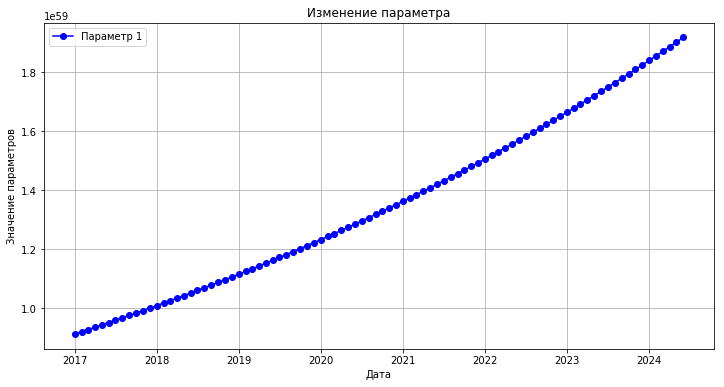

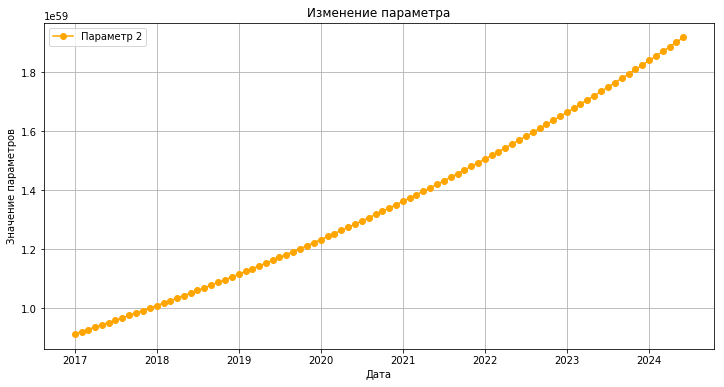

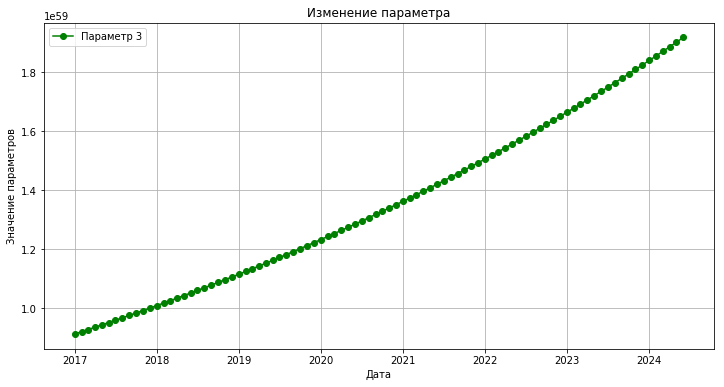

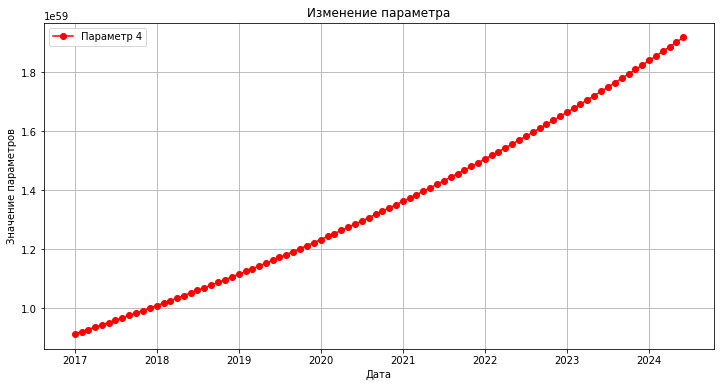

In [184]:
class ModelParamsInterpolatorExp:
    def __init__(self, known_dates, params):
        self.known_years = np.array([self._date_to_year(date) for date in known_dates])
        self.params = np.array(params)
        
        self.coefficients = [
            self._fit_exp(self.known_years, self.params[:, i])
            for i in range(self.params.shape[1])
        ]
    
    def _date_to_year(self, date_str):
        date = datetime.strptime(date_str, '%Y-%m-%d')
        year_start = datetime(date.year, 1, 1)
        year_end = datetime(date.year + 1, 1, 1)
        return date.year + (date - year_start).days / (year_end - year_start).days
    
    def _exp(self, x, a, b):
        return a * np.exp(b * x)
    
    def _fit_exp(self, x, y):
        popt, _ = curve_fit(self._exp, x, y, p0=(1, 0.1))
        return popt
        
    def get_params(self, date_str):
        year = self._date_to_year(date_str)
        return np.array([
            self._exp(year, *coeff)
            for coeff in self.coefficients
        ])
    
    
        

known_dates = ['2015-04-01', '2017-04-01', '2019-04-01', '2021-04-01']
params = np.array([
    [1.037092858751199, 16900.012216718525, 4.988853887678985, 3.474358756616286],
    [1.2422399419097152, 19449.85, 3.8058755113441967, 2.5119155759456526],
    [1.9055407806102833, 23828.75, 2.252005029581577, 1.2612232242278925],
    [1.972754199806821, 28140.15, 2.118489387972908, 1.1877967810538892],
    # [1.883881805692282, 36245.15, 2.2989098818980533, 1.2919585948589247]
])

interpolator = ModelParamsInterpolatorExp(known_dates, params)

predicted_params_dict_exp = {}

for date in df_fot['report_dt']:
    date = datetime.strftime(date, '%Y-%m-%d')
    predicted_params_dict_exp[date] = interpolator.get_params(date)
    
dates = list(predicted_params_dict_exp.keys())
params = list(predicted_params_dict_exp.values())

params_array = np.array(params)

numeric_dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

num_params = params_array.shape[1]

colors = ['blue', 'orange', 'green', 'red']


for i in range(num_params):
    plt.figure(figsize=(12, 6))
    plt.plot(numeric_dates, params_array[:, i],
            label=f"Параметр {i + 1}",
            marker="o",
            color=colors[i % len(colors)])
    
    plt.xlabel("Дата")
    plt.ylabel("Значение параметров")
    plt.title("Изменение параметра")
    plt.grid(True)
    plt.legend()
    plt.show()

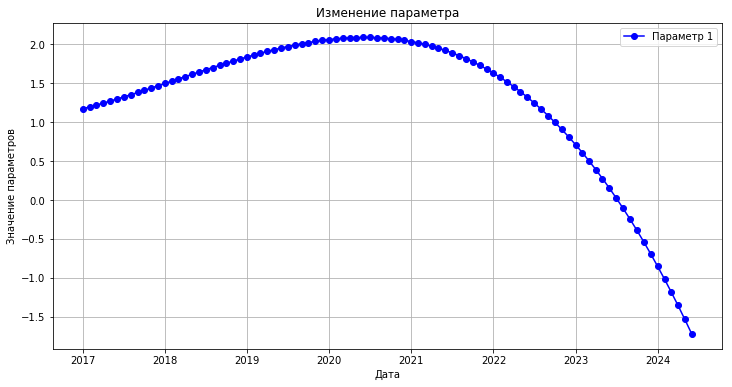

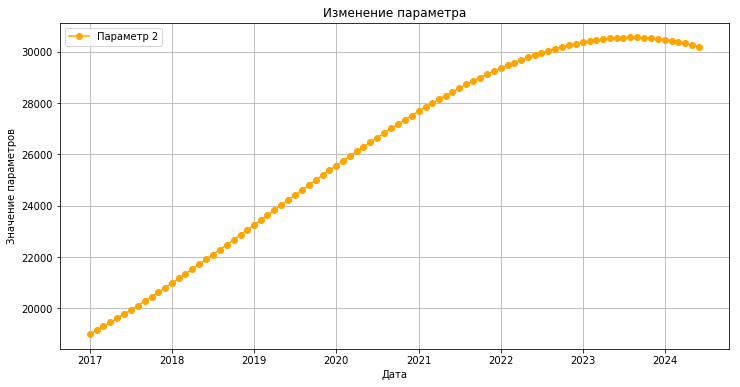

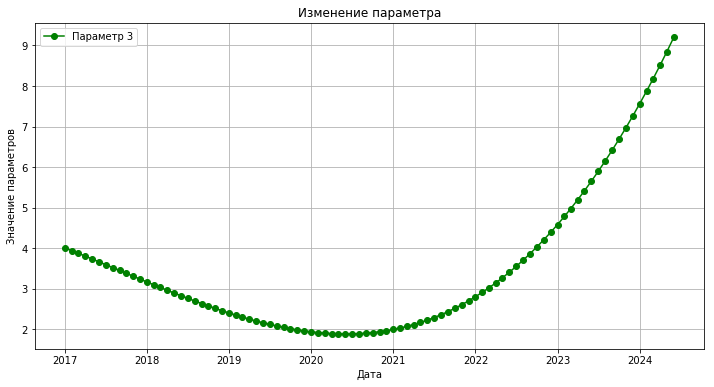

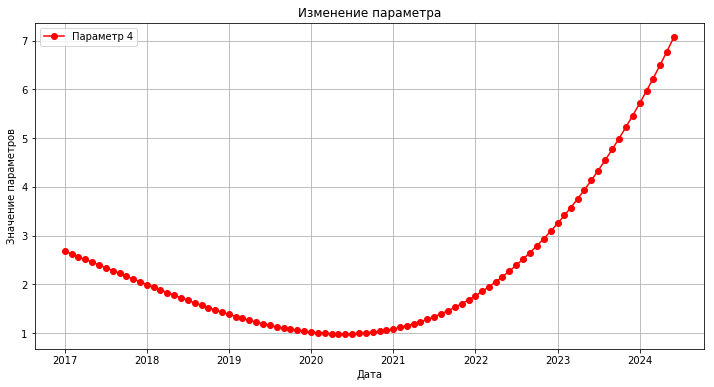

In [183]:
class ModelParamsInterpolatorSpline:
    def __init__(self, known_dates, params):
        self.known_years = np.array([self._date_to_year(date) for date in known_dates])
        self.params = np.array(params)
        
        self.interpolators = [
            interp1d(self.known_years, self.params[:, i], kind='cubic', fill_value="extrapolate")
            for i in range(self.params.shape[1])
        ]
    
    def _date_to_year(self, date_str):
        date = datetime.strptime(date_str, '%Y-%m-%d')
        year_start = datetime(date.year, 1, 1)
        year_end = datetime(date.year + 1, 1, 1)
        return date.year + (date - year_start).days / (year_end - year_start).days
    
    def get_params(self, date_str):
        year = self._date_to_year(date_str)
        return np.array([interp(year) for interp in self.interpolators])

known_dates = ['2015-04-01', '2017-04-01', '2019-04-01', '2021-04-01']
params = np.array([
    [1.037092858751199, 16900.012216718525, 4.988853887678985, 3.474358756616286],
    [1.2422399419097152, 19449.85, 3.8058755113441967, 2.5119155759456526],
    [1.9055407806102833, 23828.75, 2.252005029581577, 1.2612232242278925],
    [1.972754199806821, 28140.15, 2.118489387972908, 1.1877967810538892],
    # [1.883881805692282, 36245.15, 2.2989098818980533, 1.2919585948589247]
])

interpolator = ModelParamsInterpolatorSpline(known_dates, params)

predicted_params_dict = {}

for date in df_fot['report_dt']:
    date = datetime.strftime(date, '%Y-%m-%d')
    predicted_params_dict[date] = interpolator.get_params(date)
    
    
dates = list(predicted_params_dict.keys())
params = list(predicted_params_dict.values())

params_array = np.array(params)

numeric_dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

num_params = params_array.shape[1]

colors = ['blue', 'orange', 'green', 'red']


for i in range(num_params):
    plt.figure(figsize=(12, 6))
    plt.plot(numeric_dates, params_array[:, i],
            label=f"Параметр {i + 1}",
            marker="o",
            color=colors[i % len(colors)])
    
    plt.xlabel("Дата")
    plt.ylabel("Значение параметров")
    plt.title("Изменение параметра")
    plt.grid(True)
    plt.legend()
    plt.show()
    

In [163]:
class ModelParamsInterpolatorLinear:
    def __init__(self, known_dates, params):
        self.dates = np.array([datetime.strptime(d, '%Y-%m-%d').timestamp() for d in known_dates]) 
        self.params = np.array(params).T
        
        self.interpolators = [
            interp1d(self.dates, p, kind='linear', fill_value="extrapolate")
            for p in self.params
        ]
    
    def get_params(self, date_str):
        date_timestamp = datetime.strptime(date_str, '%Y-%m-%d').timestamp()
        return np.array([interp(date_timestamp) for interp in self.interpolators])

known_dates = ['2015-04-01', '2017-04-01', '2019-04-01', '2021-04-01']
params = np.array([
    [1.037092858751199, 16900.012216718525, 4.988853887678985, 3.474358756616286],
    [1.2422399419097152, 19449.85, 3.8058755113441967, 2.5119155759456526],
    [1.9055407806102833, 23828.75, 2.252005029581577, 1.2612232242278925],
    [1.972754199806821, 28140.15, 2.118489387972908, 1.1877967810538892],
    # [1.883881805692282, 36245.15, 2.2989098818980533, 1.2919585948589247],
])

interpolator = ModelParamsInterpolatorLinear(known_dates, params)

predicted_params_dict_lin = {}

for date in df_fot['report_dt']:
    date = datetime.strftime(date, '%Y-%m-%d')
    predicted_params_dict_lin[date] = interpolator.get_params(date)

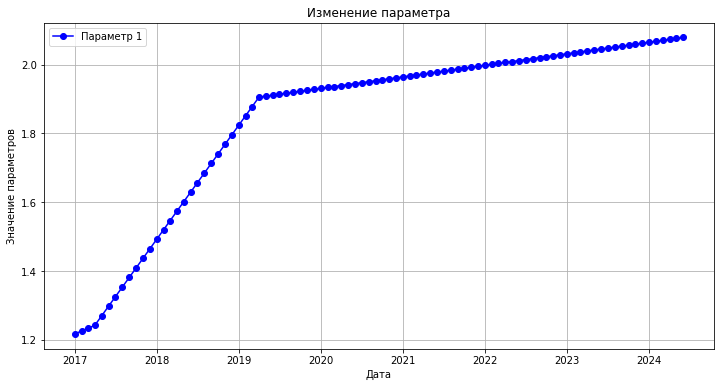

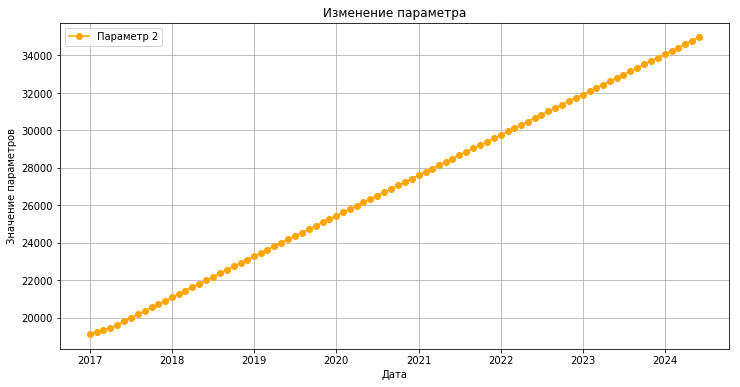

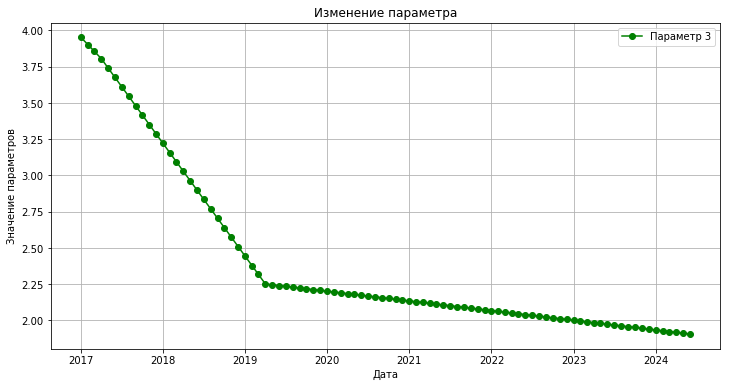

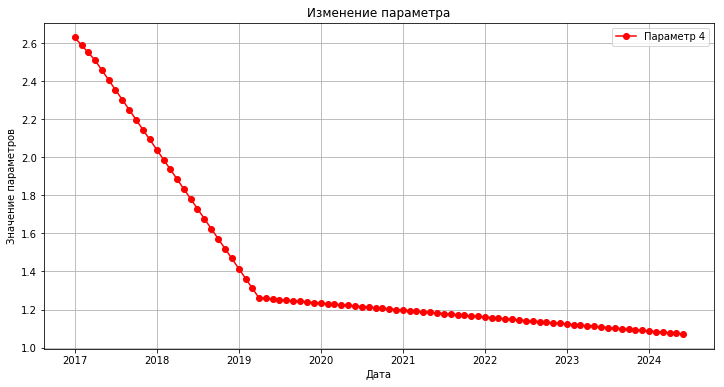

IndexError: index 4 is out of bounds for axis 1 with size 4

<Figure size 864x432 with 0 Axes>

In [164]:
dates = list(predicted_params_dict_lin.keys())
params = list(predicted_params_dict_lin.values())

params_array = np.array(params)

numeric_dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

num_params = params_array.shape[0]

colors = ['blue', 'orange', 'green', 'red']


for i in range(num_params):
    plt.figure(figsize=(12, 6))
    plt.plot(numeric_dates, params_array[:, i],
            label=f"Параметр {i + 1}",
            marker="o",
            color=colors[i % len(colors)])
    
    plt.xlabel("Дата")
    plt.ylabel("Значение параметров")
    plt.title("Изменение параметра")
    plt.grid(True)
    plt.legend()
    plt.show()

## Валидация экстраполяции всех годов => 2023


In [63]:
# 2017 params => 2019 params

params_2017 = interpolator.get_params('2019-04-01')

df_fot_2023 = df_fot[df_fot['report_dt'] == '2019-04-01']

for index, row in df_fot_2023[['report_dt', 'fot', 'Value', 'avg_salary']].iterrows():
    date = row['report_dt']
    fot_real = row['fot']
    num_workers = row['Value']
    avg_salary = row['avg_salary']
    
    print(f'\n WORKING WITH DATE {date} \n')
    
    # a_start, b_start, p_start, q_start = a_pdf_2017, b_pdf_2017, p_pdf_2017, q_pdf_2017
    
    a_opt_month, b_opt_month, p_opt_month, q_opt_month  = calibrate_on_date(*params_2017, fot_real, num_workers, avg_salary)

buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2023 = []

print(f'a :{a_opt_month}, b: {b_opt_month}, p: {p_opt_month}, q: {q_opt_month}')

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_opt_month, b_opt_month,
                                                                        p_opt_month, q_opt_month, num_workers_2023_bill)
        result_2023.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2023 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1132340133606.4, 507418803557.1, 235800886118.4, 102409556954.8, 59576972957.7], 
    'true_num_workers' : [23231071, 3779433, 887636, 185304, 24400],
    'true_avg_salary' : [48742.48538, 134257.9, 265650.5, 552657.5, 2441688.2]
})      
       
result_2023 = pd.DataFrame(result_2023)
result_2023_final_det = pd.merge(result_2023, true_2023, on='bucket')
result_2023_final_det['fot_error'] = 1 - result_2023_final_det['fot'] / result_2023_final_det['true_fot']
result_2023_final_det['num_workers_error'] = 1 - result_2023_final_det['num_workers'] / result_2023_final_det['true_num_workers']
result_2023_final_det['avg_salary_error'] = 1 - result_2023_final_det['avg_salary'] / result_2023_final_det['true_avg_salary']
# result_2023_final_det.to_excel('result_2023_final_det_nonlog.xlsx')
result_2023_final_det


 WORKING WITH DATE 2019-04-01 00:00:00 


 CALIBRATING 

a_start = 1.8602707726023562
b_start = 21644.520244691368
p_start = 2.605827393189317
q_start = 1.2772975887512454
FOT RMSE:        3480585199.1591797
num_workers MSE: 604.4588143093514
avg_salary MSE : 6256570.960952225

FOT RMSE:        103216796708.9961
num_workers MSE: 127.7546362463975
avg_salary MSE : 5498562405.39

FOT RMSE:        107971276019.95874
num_workers MSE: 762.1884844699165
avg_salary MSE : 6016992299.945114

FOT RMSE:        63776899449.552734
num_workers MSE: 681.0256110493319
avg_salary MSE : 2099403028.0515888

FOT RMSE:        109695381384.94751
num_workers MSE: 138.40033247120306
avg_salary MSE : 6210480010.861053

FOT RMSE:        157024352037.60962
num_workers MSE: 1495.6730509947504
avg_salary MSE : 12726147659.475677

FOT RMSE:        48771693821.56128
num_workers MSE: 248.2464373987577
avg_salary MSE : 1227653538.7200303

FOT RMSE:        150236373536.8142
num_workers MSE: 145.73017263539143
avg_sala

KeyboardInterrupt: 

In [ ]:
# 2019 params => 2021 params
a_start = 1.8602707726023562
b_start = 21644.520244691368
p_start = 2.605827393189317 
q_start = 1.2772975887512454


df_fot_2023 = df_fot[df_fot['report_dt'] == '2021-04-01']

for index, row in df_fot_2023[['report_dt', 'fot', 'Value', 'avg_salary']].iterrows():
    date = row['report_dt']
    fot_real = row['fot']
    num_workers = row['Value']
    avg_salary = row['avg_salary']
    
    print(f'\n WORKING WITH DATE {date} \n')
    
    # a_start, b_start, p_start, q_start = a_pdf_2017, b_pdf_2017, p_pdf_2017, q_pdf_2017
    
    a_opt_month, b_opt_month, p_opt_month, q_opt_month  = calibrate_on_date(a_start, b_start, p_start, 
                                                                            q_start, fot_real, num_workers, avg_salary)

buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2023 = []

print(f'a :{a_opt_month}, b: {b_opt_month}, p: {p_opt_month}, q: {q_opt_month}')

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_opt_month, b_opt_month,
                                                                        p_opt_month, q_opt_month, num_workers_2023_bill)
        result_2023.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2023 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1132340133606.4, 507418803557.1, 235800886118.4, 102409556954.8, 59576972957.7], 
    'true_num_workers' : [23231071, 3779433, 887636, 185304, 24400],
    'true_avg_salary' : [48742.48538, 134257.9, 265650.5, 552657.5, 2441688.2]
})      
       
result_2023 = pd.DataFrame(result_2023)
result_2023_final_det = pd.merge(result_2023, true_2023, on='bucket')
result_2023_final_det['fot_error'] = 1 - result_2023_final_det['fot'] / result_2023_final_det['true_fot']
result_2023_final_det['num_workers_error'] = 1 - result_2023_final_det['num_workers'] / result_2023_final_det['true_num_workers']
result_2023_final_det['avg_salary_error'] = 1 - result_2023_final_det['avg_salary'] / result_2023_final_det['true_avg_salary']
# result_2023_final_det.to_excel('result_2023_final_det_nonlog.xlsx')
result_2023_final_det

In [154]:
# до 2021 params => 2023 params

df_fot_2023 = df_fot[df_fot['report_dt'] == '2023-04-01']

for index, row in df_fot_2023[['report_dt', 'fot', 'Value', 'avg_salary']].iterrows():
    date = row['report_dt']
    fot_real = row['fot']
    num_workers = row['Value']
    avg_salary = row['avg_salary']
    
    print(f'\n WORKING WITH DATE {date} \n')
    
    # a_start, b_start, p_start, q_start = a_pdf_2017, b_pdf_2017, p_pdf_2017, q_pdf_2017
    
    a_start, b_start, p_start, q_start = predicted_params_dict_lin['2023-04-01']
    
    a_opt_month, b_opt_month, p_opt_month, q_opt_month  = calibrate_on_date(a_start, b_start, p_start, 
                                                                            q_start, fot_real, num_workers, avg_salary)

buckets = [(1, 100_000), (100_000.01, 200_000), (200_000.01, 400_000), (400_000.01, 1_000_000), (1_000_000.01, 2_000_000), (2_000_000.01, 3_000_000), (3_000_000.01, 15_000_000)]

result_2023 = []

print(f'a :{a_opt_month}, b: {b_opt_month}, p: {p_opt_month}, q: {q_opt_month}')

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_opt_month, b_opt_month,
                                                                        p_opt_month, q_opt_month, num_workers_2023_bill)
        result_2023.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2023 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1132340133606.4, 507418803557.1, 235800886118.4, 102409556954.8, 23325585019.4, 7867648076.8, 28383739861.5], 
    'true_num_workers' : [23231071, 3779433, 887636, 185304, 17454.61, 3250.99, 3694.31],
    'true_avg_salary' : [48742.48538, 134257.9, 265650.5, 552657.5, 1336356.7, 2420077.6, 7683096.4]
})      
       
result_2023 = pd.DataFrame(result_2023)
result_2023_final_det = pd.merge(result_2023, true_2023, on='bucket')
result_2023_final_det['fot_error'] = 1 - result_2023_final_det['fot'] / result_2023_final_det['true_fot']
result_2023_final_det['num_workers_error'] = 1 - result_2023_final_det['num_workers'] / result_2023_final_det['true_num_workers']
result_2023_final_det['avg_salary_error'] = 1 - result_2023_final_det['avg_salary'] / result_2023_final_det['true_avg_salary']
# result_2023_final_det.to_excel('result_2023_final_det_nonlog.xlsx')
result_2023_final_det


 WORKING WITH DATE 2023-04-01 00:00:00 


 CALIBRATING 

a_start = 2.0398756717814757
b_start = 35083.10500066632
p_start = 1.9851563943007762
q_start = 1.1144707844505755
a_opt_new = 2.057567929336396
b_opt_new = 35083.10500066632
p_opt_new = 2.007713071729185
q_opt_new = 1.1094225662529293
real FOT = 3025785907865.91
pred FOT = 3025785908137.9517
ERROR = 8.990774791328704e-11
real num_workers = 43123120.2
pred num_workers = 43123030.067045115
ERROR_num_workers = -2.09013501017985e-06
real avg_salary = 70166.21000133264
pred avg_salary = 70166.3566644932
ERROR_avg_salary = 2.090220549089139e-06
a :2.057567929336396, b: 35083.10500066632, p: 2.007713071729185, q: 1.1094225662529293

 CALCULATING 1-100000 


 CALCULATING 100000.01-200000 


 CALCULATING 200000.01-400000 


 CALCULATING 400000.01-1000000 


 CALCULATING 1000000.01-2000000 


 CALCULATING 2000000.01-3000000 


 CALCULATING 3000000.01-15000000 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,1.121081e+12,2.354760e+07,4.760914e+04,1.132340e+12,23231071.00,4.874249e+04,0.009943,-0.013625,0.023252
1,100000.01-200000,4.668952e+11,3.489403e+06,1.338037e+05,5.074188e+11,3779433.00,1.342579e+05,0.079862,0.076739,0.003383
2,200000.01-400000,2.232628e+11,8.431542e+05,2.647944e+05,2.358009e+11,887636.00,2.656505e+05,0.053172,0.050113,0.003223
3,400000.01-1000000,1.120279e+11,1.993015e+05,5.620996e+05,1.024096e+11,185304.00,5.526575e+05,-0.093920,-0.075538,-0.017085
4,1000000.01-2000000,2.973688e+10,2.253747e+04,1.319384e+06,2.332559e+10,17454.61,1.336357e+06,-0.274861,-0.291204,0.012701
5,2000000.01-3000000,8.426866e+09,3.524464e+03,2.390286e+06,7.867648e+09,3250.99,2.420078e+06,-0.071078,-0.084120,0.012310
6,3000000.01-15000000,1.078949e+10,2.255846e+03,4.780780e+06,2.838374e+10,3694.31,7.683096e+06,0.619871,0.389373,0.377753


In [ ]:
# Сам 2023 год
a: 2.127430969027937 b: 41698.103397986 p: 1.6435657731975595 q: 1.1147940932489737

# Начальные параметры от 2017

In [153]:
df_fot_2021 = df_fot[df_fot['report_dt'] == '2021-04-01']

for index, row in df_fot_2021[['report_dt', 'fot', 'Value', 'avg_salary']].iterrows():
    date = row['report_dt']
    fot_real = row['fot']
    num_workers = row['Value']
    avg_salary = row['avg_salary']
    
    print(f'\n WORKING WITH DATE {date} \n')
    
    a_start, b_start, p_start, q_start = a_pdf_2019, b_pdf_2019, p_pdf_2019, q_pdf_2019
    
    a_opt_month, b_opt_month, p_opt_month, q_opt_month  = calibrate_on_date(a_start, b_start, p_start, 
                                                                            q_start, fot_real, num_workers, avg_salary)

buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2021 = []

print(f'a :{a_opt_month}, b: {b_opt_month}, p: {p_opt_month}, q: {q_opt_month}')

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end,  a_opt_month, b_opt_month, p_opt_month, 
                                                                        q_opt_month, num_workers_2021_bill)
        
        result_2021.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2021 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1019722032699, 297162900607.2, 132787959244.4, 56637829332.3, 42168571452], 
    'true_num_workers' : [24676470, 2217132, 501879, 101106, 17103],
    'true_avg_salary' : [41323.65822, 134257.9, 264581.8, 560185.0, 2465506.671]
})       
       
result_2021 = pd.DataFrame(result_2021)
result_2021_final_det = pd.merge(result_2021, true_2021, on='bucket')
result_2021_final_det['fot_error'] = 1 - result_2021_final_det['fot'] / result_2021_final_det['true_fot']
result_2021_final_det['num_workers_error'] = 1 - result_2021_final_det['num_workers'] / result_2021_final_det['true_num_workers']
result_2021_final_det['avg_salary_error'] = 1 - result_2021_final_det['avg_salary'] / result_2021_final_det['true_avg_salary']
# result_2021_final_det.to_excel('result_2021_final_det.xlsx')
result_2021_final_det


 WORKING WITH DATE 2021-04-01 00:00:00 


 CALIBRATING 

a_start = 1.9055407806102833
b_start = 27919.53535964195
p_start = 2.252005029581577
q_start = 1.2612232242278925


KeyboardInterrupt: 

In [ ]:
# Сам 2021 год


# Начальные параметры 2019


In [147]:
buckets = [(2, 100_000), (100_000.1, 150_000), (150_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000.01, 100_000_000)]

df_fot_2023 = df_fot[df_fot['report_dt'].between('2020-01-01', '2024-09-01')]

result_2023 = []

for index, row in df_fot_2023[['report_dt', 'fot', 'Value', 'avg_salary']].iterrows():
    date = row['report_dt']
    fot_real = row['fot']
    num_workers = row['Value']
    avg_salary = row['avg_salary']
    
    print(f'\n WORKING WITH DATE {date} \n')
    
    date = datetime.strftime(date, '%Y-%m-%d')
    
    a_start, b_start, p_start, q_start = predicted_params_dict_lin[date]
    
    a_opt_month, b_opt_month, p_opt_month, q_opt_month  = calibrate_on_date(a_start, b_start, p_start, 
                                                                            q_start, fot_real, num_workers, avg_salary)
    
    for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_opt_month, b_opt_month, 
                                                                        p_opt_month, q_opt_month, num_workers)
        result_2023.append({
            'report_dt' : date, 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

df_2023 = pd.DataFrame(result_2023)


 WORKING WITH DATE 2020-01-01 00:00:00 


 CALIBRATING 

a_start = 1.9308262666281326
b_start = 23074.303755641045
p_start = 2.201776847033856
q_start = 1.233600417288288
a_opt_new = 1.950639089147117
b_opt_new = 23074.303755641045
p_opt_new = 2.232421231397029
q_opt_new = 1.226192957602371
real FOT = 2040143363286.09
pred FOT = 2040143362987.9133
ERROR = -1.4615486598756888e-10
real num_workers = 44208124.0
pred num_workers = 44208103.06462118
ERROR_num_workers = -4.735642873399115e-07
real avg_salary = 46148.60751128209
pred avg_salary = 46148.62935886967
ERROR_avg_salary = 4.734179083198953e-07

 CALCULATING 2-100000 


 CALCULATING 100000.1-150000 


 CALCULATING 150000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000.01-100000000 


 WORKING WITH DATE 2020-02-01 00:00:00 


 CALIBRATING 

a_start = 1.9336766305065083
b_start = 23345.704907450574
p_start = 2.196114761001204
q_start = 1.2304865735969144
a_opt_new = 1.9535825095231485
b_opt_new = 23345.704907450574


In [148]:
df_2023.to_excel(r'2022_2023_nonlog_with_b_fix_and_params_approx.xlsx', 
                      index=False)

In [50]:
df_2023.to_excel(r'\\admira203.ca.sbrf.ru\vol4\HQRB_VARM\Клиентские пути\Влад\FOT\bucket_in_years\2023_new.xlsx', 
                      index=False)

## 2022 - 2023 года график с доверительным интервалом

In [40]:
df_2022_2023 = pd.read_excel(r'2022_2023_23_10.xlsx')
df_2022_2023 = df_2022_2023.groupby(by='report_dt').agg({
    'fot' : 'sum',
    'num_workers' : 'sum'
}  
).reset_index()

df_2022_2023['avg_salary'] = df_2022_2023['fot'] / df_2022_2023['num_workers']
df_2022_2023['report_dt'] = pd.to_datetime(df_2022_2023['report_dt'])
df_2022_2023

,report_dt,fot,num_workers,avg_salary
0,2022-01-01,2.381874e+12,4.325842e+07,55061.518514
1,2022-02-01,2.452901e+12,4.319673e+07,56784.411645
2,2022-03-01,2.864578e+12,4.329422e+07,66165.363669
3,2022-04-01,2.665865e+12,4.318397e+07,61732.744726
4,2022-05-01,2.664349e+12,4.301409e+07,61941.313640
5,2022-06-01,2.832711e+12,4.287347e+07,66071.433708
6,2022-07-01,2.626052e+12,4.264330e+07,61581.814122
7,2022-08-01,2.526116e+12,4.257095e+07,59338.959892
8,2022-09-01,2.613348e+12,4.264010e+07,61288.504441
9,2022-10-01,2.639249e+12,4.263549e+07,61902.628017


In [41]:
df_fact_2022_2023 = df_fot[df_fot['report_dt'].between('2022-01-01', '2024-06-01')]
df_fact_2022_2023 = df_fact_2022_2023.rename(columns={'Value' : 'num_workers'})
df_fact_2022_2023['report_dt'] = pd.to_datetime(df_fact_2022_2023['report_dt'])
df_fact_2022_2023

,report_dt,region,fot,num_workers,avg_salary
report_dt,,,,,
2022-01-01,2022-01-01,Российская Федерация,2.375718e+12,43258442.6,54919.174637
2022-02-01,2022-02-01,Российская Федерация,2.445864e+12,43196751.0,56621.482292
2022-03-01,2022-03-01,Российская Федерация,2.851045e+12,43294249.7,65852.734974
2022-04-01,2022-04-01,Российская Федерация,2.655792e+12,43184000.3,61499.441042
2022-05-01,2022-05-01,Российская Федерация,2.654171e+12,43014120.3,61704.651862
2022-06-01,2022-06-01,Российская Федерация,2.819389e+12,42873497.6,65760.646997
2022-07-01,2022-07-01,Российская Федерация,2.616207e+12,42643329.2,61350.918142
2022-08-01,2022-08-01,Российская Федерация,2.517727e+12,42570976.2,59141.861360
2022-09-01,2022-09-01,Российская Федерация,2.603701e+12,42640131.5,61062.218886


In [42]:
from scipy.stats import t, norm

def plot_with_conf(df_fact, df_model, column, alpha=0.05):
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(x=df_fact['report_dt'], y=df_fact[column], color='green', label='Данные Факт')
    
    mean_fact = df_fact[column].mean()
    std_fact = np.std(df_fact[column], ddof=1)
    n = len(df_fact)
    
    t_value = t.ppf(1 - alpha / 2, df=n-1)
    # z_value = norm.ppf(1 - alpha / 2)
    
    ci_95 = t_value * std_fact / np.sqrt(n)
    # ci_95 = z_value * std_fact / np.sqrt(n)
    
    plt.fill_between(df_fact['report_dt'], df_fact[column] - ci_95, df_fact[column] + ci_95, color='green', 
                     alpha=0.2, label=f'{int((1-alpha)*100)}% доверительный интервал', hatch='//')
    
    sns.lineplot(x=df_model['report_dt'], y=df_model[column], color='blue', label='Данные Модель')
    
    plt.title(f'Сравнение модельных и фактических данных {column}')
    plt.xlabel('Дата')
    plt.ylabel(column)
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlim(df_model['report_dt'].min(), df_model['report_dt'].max())
    plt.show()  

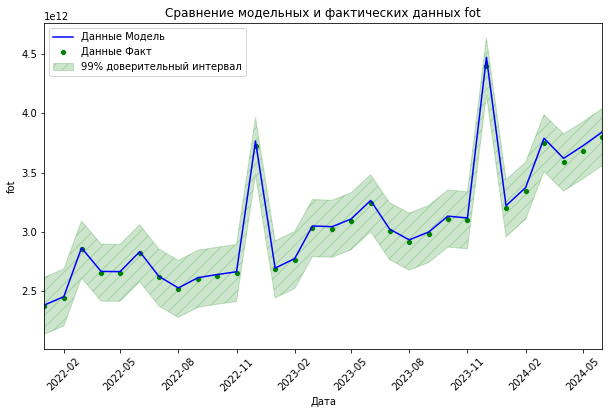

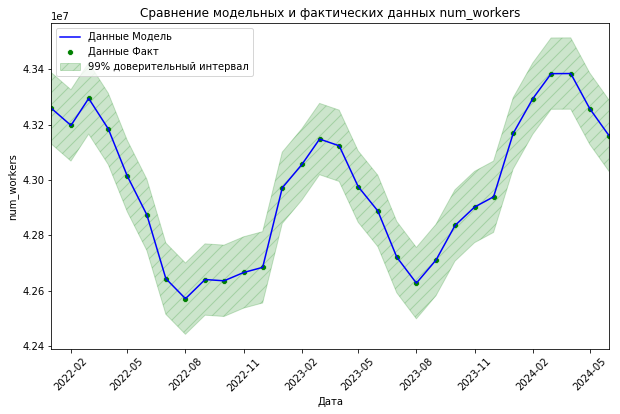

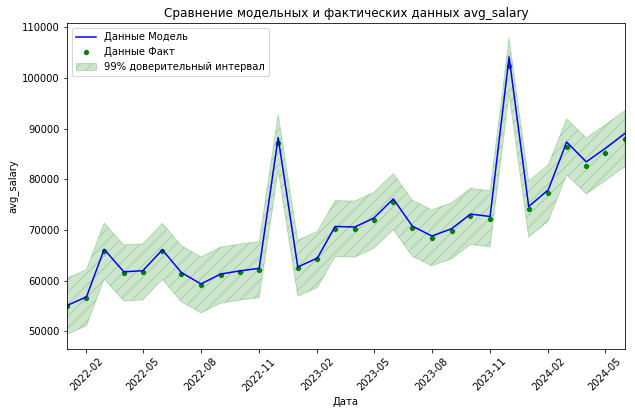

In [43]:
alpha = 0.01

for column in ['fot', 'num_workers', 'avg_salary']:
    plot_with_conf(df_fact_2022_2023, df_2022_2023, column, alpha=alpha)

## 2021 Тестирование экстраполяции

In [40]:
df_2021_detailed = df_fot[df_fot['report_dt'] == '2023-04-01']
df_2021_detailed

,report_dt,region,fot,Value,avg_salary
report_dt,,,,,
2023-04-01,2023-04-01,Российская Федерация,3.025786e+12,43123120.2,70166.210001


In [44]:
fot_train, num_workers_train, avg_salary_train = df_2021_detailed[['fot', 'Value', 'avg_salary']].values.T

In [ ]:
# a = 20.59417753558644
# b_cdf = 11.284144023181453
# p_cdf = 1.0752867698890636
# q_cdf = 2.1093254680828983

In [49]:
a_opt_new, b_opt_new, p_opt_new, q_opt_new  = calibrate_on_date(a_start=20.59417753558644, b_start=11.284144023181453, 
                                                                p_start=1.0752867698890636, q_start=2.1093254680828983, 
                                                                fot_real=fot_train, num_workers=num_workers_train, 
                                                                avg_salary=avg_salary_train)


 CALIBRATING 

a_start = 20.59417753558644
b_start = 11.284144023181453
p_start = 1.0752867698890636
q_start = 2.1093254680828983
FOT RMSE:        [2.54450993e+11]
num_workers MSE: [9.40933462]
avg_salary MSE : [3.48166909e+11]

FOT RMSE:        [2.54450993e+11]
num_workers MSE: [9.40933417]
avg_salary MSE : [3.48166909e+11]

FOT RMSE:        [2.54450965e+11]
num_workers MSE: [9.40933476]
avg_salary MSE : [3.48166833e+11]

FOT RMSE:        [2.54450976e+11]
num_workers MSE: [9.40933444]
avg_salary MSE : [3.48166863e+11]

FOT RMSE:        [2.54451004e+11]
num_workers MSE: [9.4093312]
avg_salary MSE : [3.4816694e+11]

FOT RMSE:        [6.08720668e+13]
num_workers MSE: [7.48241473e+10]
avg_salary MSE : [2.01937399e+16]

FOT RMSE:        [6.08720668e+13]
num_workers MSE: [7.48241469e+10]
avg_salary MSE : [2.01937399e+16]

FOT RMSE:        [6.08720674e+13]
num_workers MSE: [7.48241507e+10]
avg_salary MSE : [2.01937403e+16]

FOT RMSE:        [6.08720672e+13]
num_workers MSE: [7.48241492e+10]

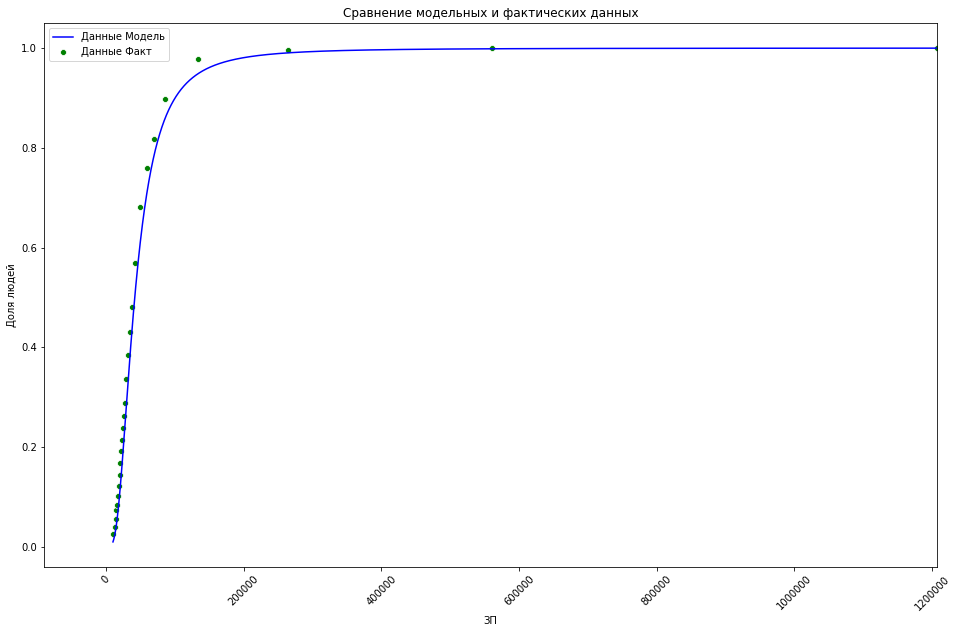

In [51]:
# a_opt_new = 17.72548374150287
# b_opt_new = 10.578088107154558
# p_opt_new = 2.2042595359410027
# q_opt_new = 1.9788653694494196

def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))
    
x_true = np.log(df_2021['Ср зп'])
y_true = df_2021['cumsum']

x_model = np.log(np.arange(df_2021['Ср зп'].min(), df_2021['Ср зп'].max(), dtype=np.int32))
y_model = gb2_cdf(x_model, a_opt_new, b_opt_new, p_opt_new, q_opt_new )


plt.figure(figsize=(16, 10))
    
sns.scatterplot(x=np.exp(x_true), y=y_true, color='green', label='Данные Факт')
    
sns.lineplot(x=np.exp(x_model), y=y_model, color='blue', label='Данные Модель')
    
plt.title(f'Сравнение модельных и фактических данных')
plt.xlabel('ЗП')
plt.ylabel('Доля людей')
plt.legend()
plt.xticks(rotation=45)
plt.xlim(df_2021['Ср зп'].min() - 100_000, df_2021['Ср зп'].max())
plt.show()

In [50]:
buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2021 = []

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_opt_new, b_opt_new, p_opt_new, q_opt_new, num_workers=27513690)
        result_2021.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2021 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1019722032699, 297162900607.2, 132787959244.4, 56637829332.3, 42168571452], 
    'true_num_workers' : [24676470, 2217132, 887636, 501879, 17103],
    'true_avg_salary' : [41323.65822, 134257.9, 264581.8, 560185.0, 2465506.671]
})      
       
result_2021 = pd.DataFrame(result_2021)
result = pd.merge(result_2021, true_2021, on='bucket')
result['fot_error'] = 1 - result['fot'] / result['true_fot']
result['num_workers_error'] = 1 - result['num_workers'] / result['true_num_workers']
result['avg_salary_error'] = 1 - result['avg_salary'] / result['true_avg_salary']
result


 CALCULATING 1-100000 


 CALCULATING 100000.1-200000 


 CALCULATING 200000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,1.083862e+12,2.229372e+07,4.861736e+04,1.019722e+12,24676470,4.132366e+04,-0.062900,0.096559,-0.176502
1,100000.1-200000,5.736885e+11,4.307746e+06,1.331760e+05,2.971629e+11,2217132,1.342579e+05,-0.930552,-0.942936,0.008058
2,200000.1-400000,2.064346e+11,7.993958e+05,2.582380e+05,1.327880e+11,887636,2.645818e+05,-0.554619,0.099410,0.023977
3,400000.1-1000000,5.678239e+10,1.061714e+05,5.348132e+05,5.663783e+10,501879,5.601850e+05,-0.002552,0.788452,0.045292
4,1000000-15000001,9.749940e+09,6.528087e+03,1.493308e+06,4.216857e+10,17103,2.465507e+06,0.768787,0.618308,0.394320
